In [1]:
library(dplyr)
library(ggplot2)
library(glmnet)
library(leaps)
library(Metrics)
library(purrr)
library(reshape2)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loaded glmnet 4.1-4


Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [2]:
# Import Data
dfAll <- read.csv("../input/wine-quality-dataset/WineQT.csv")
df <- subset(dfAll, select=-Id)

# Make data binary
zero<-subset(df, quality<6)
zero$quality_bin=0

one<-subset(df,quality>5)
one$quality_bin=1

df_bin<-rbind(zero,one)
df_bin <- subset(df_bin, select=-quality)

Y = df_bin["quality_bin"]
X = subset(df_bin, select=-quality_bin)

# **Exploratory Analysis**

In [3]:
colnames(df_bin)

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "quality_bin"

In [4]:
# Check for missing/null values
print(which(is.na(df_bin)))

integer(0)


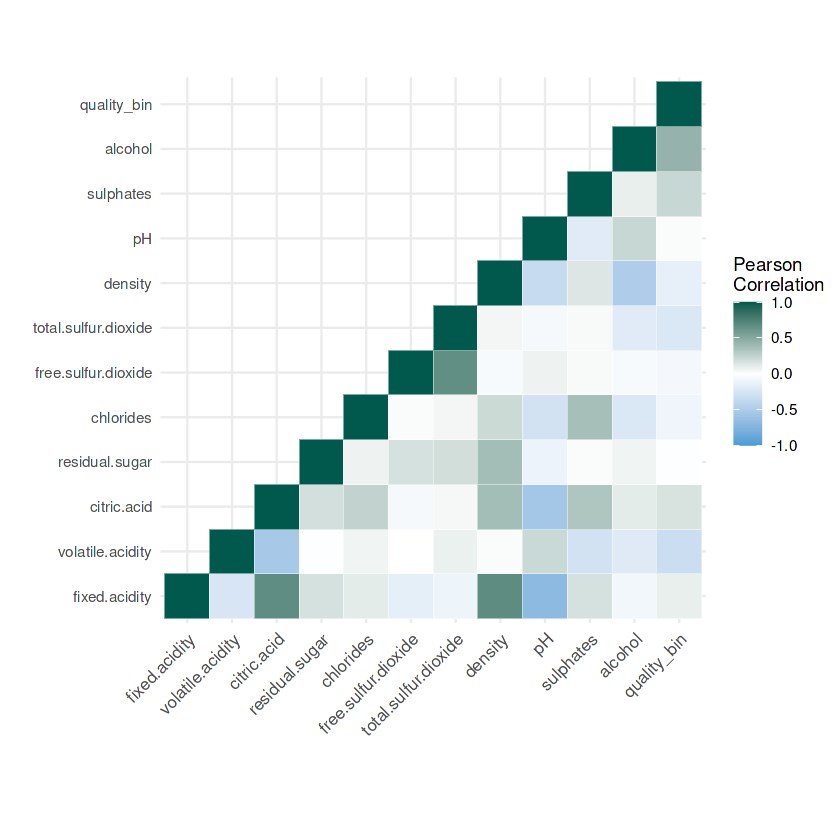

In [5]:
# Look at correlations between X variables / heat map
cormap <- round(cor(df_bin),2)
melted_cormap <- melt(cormap)

#making upper triangular matrix
make_upper_tri <- function(cormap){
   cormap[lower.tri(cormap)]<- NA
   return(cormap)
 }
upper_tri <- make_upper_tri(cormap)
melted_cormap <- melt(upper_tri, na.rm = TRUE)

#plotting heatmap, NA values plotted as blank squares
ggplot(data = melted_cormap, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "#4B9CD3", high = "#00594C", midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
  theme_minimal()+ 
labs(x = "", y="")+
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 10, hjust = 1))+
 coord_fixed()

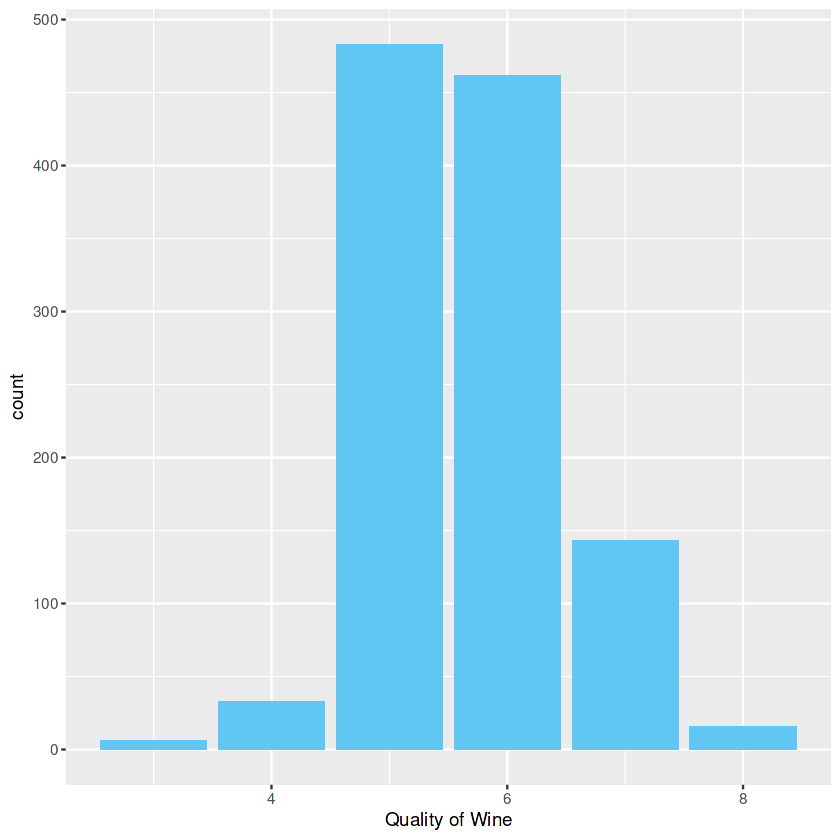

In [6]:
# Remove Fixed Acidity due to high correlation with density, pH, and citric acid
df_bin = subset(df_bin, select=-fixed.acidity)

Y = df["quality"]

# Histogram for Quality
ggplot(Y, aes(quality)) + labs(x = "Quality of Wine") +
  geom_bar(fill = "#62C6F2")

quality_bin,counts
<dbl>,<int>
0,522
1,621


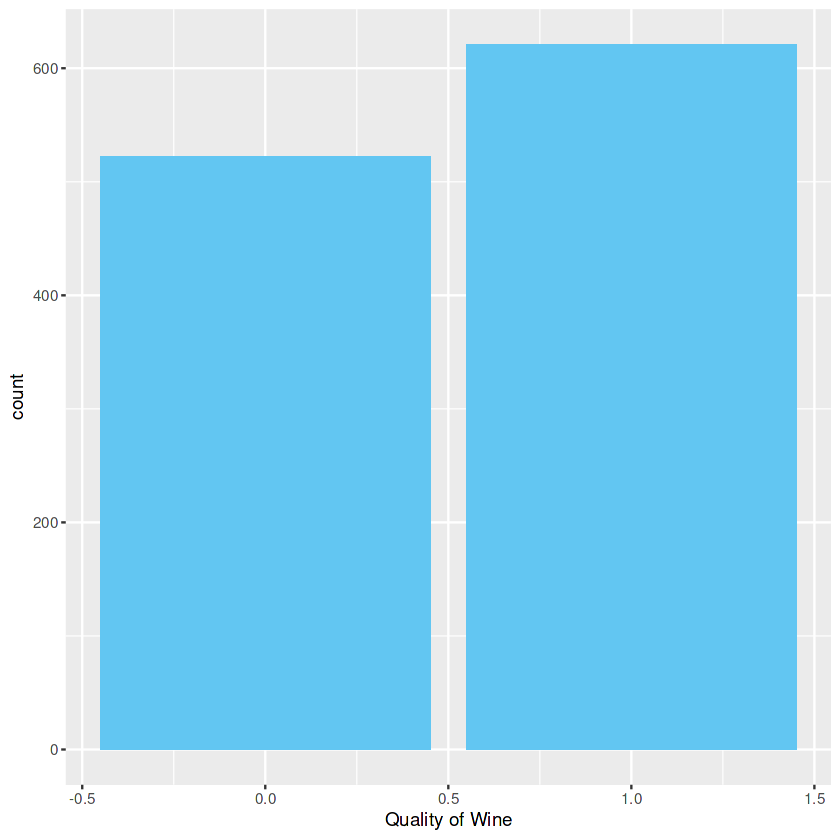

In [7]:
# Response variable investigation
Y = df_bin["quality_bin"]

summaryY <- df_bin %>%
  group_by(quality_bin) %>%
  summarize(counts = n())

summaryY

# Histogram for Quality
ggplot(df_bin, aes(quality_bin)) + labs(x = "Quality of Wine") +
  geom_bar(fill = "#62C6F2")

## Split into Training and Testing Data
We split the data 80% train, 20% test

In [8]:
sample <- sample(c(TRUE, FALSE), nrow(df_bin), replace=TRUE, prob=c(0.8,0.2))
train <- df_bin[sample, ]
test <- df_bin[!sample, ]

## Basic Model Logistic Regression

In [9]:
log_mod = glm(formula=quality_bin~.,data=train,family="binomial")
summary(log_mod)

logRegAIC <- AIC(log_mod)
logRegBIC <- BIC(log_mod)

trainPrediction <- predict(log_mod)
logRegRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(log_mod, test)
logRegRMSETest <- rmse(testPrediction, test$quality_bin)

print(c(logRegRMSETrain, logRegRMSETest, logRegAIC, logRegBIC))


Call:
glm(formula = quality_bin ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5910  -0.8166   0.2694   0.8201   2.4407  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -61.441135  69.978146  -0.878 0.379941    
volatile.acidity      -3.273978   0.657788  -4.977 6.45e-07 ***
citric.acid           -0.817524   0.712241  -1.148 0.251043    
residual.sugar        -0.019304   0.070094  -0.275 0.783004    
chlorides             -3.907122   2.014720  -1.939 0.052466 .  
free.sulfur.dioxide    0.022193   0.011238   1.975 0.048289 *  
total.sulfur.dioxide  -0.013687   0.003589  -3.814 0.000137 ***
density               56.068592  69.704138   0.804 0.421178    
pH                    -1.270187   0.648501  -1.959 0.050154 .  
sulphates              3.197023   0.645976   4.949 7.45e-07 ***
alcohol                1.008712   0.126555   7.971 1.58e-15 ***
---
Signif. codes:  0 ‘***’ 0.

[1]   1.409611   1.353242 939.237614 992.124899


### Checking for outliers, points of influence, and leverage points

In [10]:
# Pearson Standardized Residuals
res <- data.frame(residual = ((residuals(log_mod, "pearson"))/sqrt(1 - hatvalues(log_mod))))

# Outliers 
outliers <- subset(res, abs(residual) > 3)
outliers

,residual
,<dbl>
249,-4.039120
515,-4.560930
637,-3.135827
1019,-5.273374
1079,-3.094558
166,4.330934
1029,3.190912


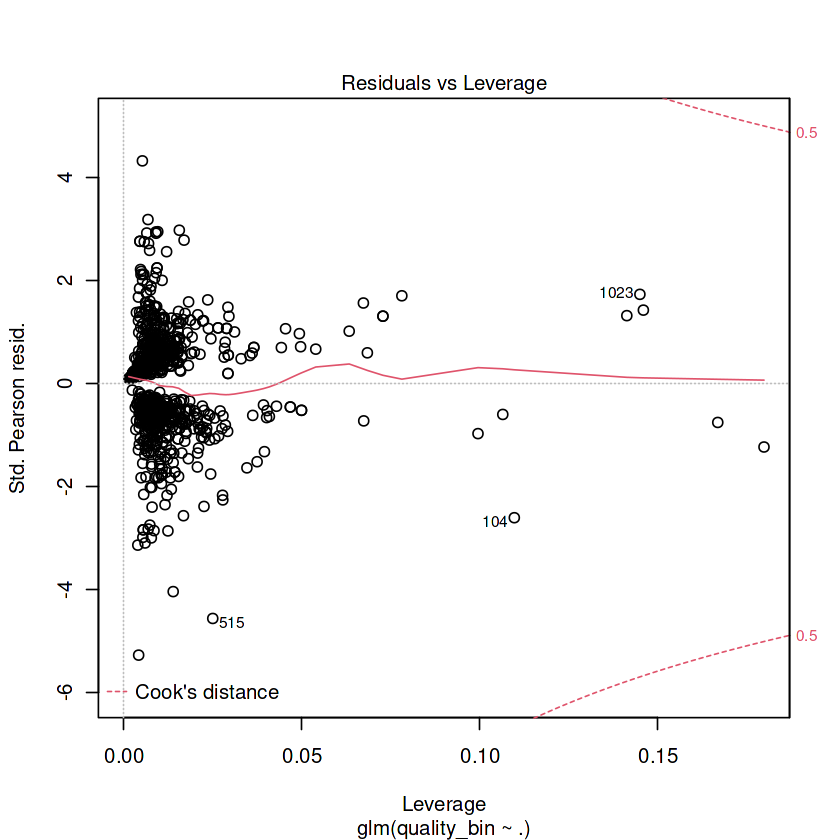

In [11]:
# Influential points

#Cook's distance
plot(log_mod,5)
cooks <- data.frame(cooksDistance = cooks.distance(log_mod))

In [12]:
# Leverage points
leverage <- data.frame(hatvalues = hatvalues(log_mod))
highLeverage <- subset(leverage, abs(hatvalues) > 2)
highLeverage

#No points of high leverage

hatvalues
<dbl>


In [13]:
# Remove Outliers and Influential Points
indexes <- data.frame(as.integer(rownames(outliers)))
outliersIndex <- c()
for (i in indexes){
  outliersIndex <- c(outliersIndex, i) 
}

df_bin <- df_bin[-outliersIndex]

# Resplit data wihtout outliers
sample <- sample(c(TRUE, FALSE), nrow(df_bin), replace=TRUE, prob=c(0.8,0.2))
train <- df_bin[sample, ]
test <- df_bin[!sample, ]

## Rerun Basic Logistic Model

In [14]:
log_mod = glm(formula=quality_bin~.,data=train,family="binomial")
summary(log_mod)

logRegAIC <- AIC(log_mod)
logRegBIC <- BIC(log_mod)

trainPrediction <- predict(log_mod)
logRegRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(log_mod, test)
logRegRMSETest <- rmse(testPrediction, test$quality_bin)

print(c(logRegRMSETrain, logRegRMSETest, logRegAIC, logRegBIC))


Call:
glm(formula = quality_bin ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3834  -0.8308   0.3183   0.7971   2.3639  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.351e+02  7.132e+01  -1.895 0.058118 .  
volatile.acidity     -3.287e+00  6.375e-01  -5.155 2.53e-07 ***
citric.acid          -1.268e+00  7.096e-01  -1.787 0.073949 .  
residual.sugar       -4.106e-02  7.053e-02  -0.582 0.560421    
chlorides            -3.699e+00  2.011e+00  -1.839 0.065843 .  
free.sulfur.dioxide   1.211e-02  1.119e-02   1.082 0.279053    
total.sulfur.dioxide -1.233e-02  3.719e-03  -3.315 0.000916 ***
density               1.283e+02  7.103e+01   1.806 0.070950 .  
pH                   -8.205e-01  6.655e-01  -1.233 0.217628    
sulphates             2.951e+00  6.219e-01   4.745 2.08e-06 ***
alcohol               1.083e+00  1.308e-01   8.285  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.

[1]   1.359462   1.335861 929.628894 982.319964


## Backward Selection
Note we use a p-value of 0.05 as the stopping rule.

In [15]:
summary(log_mod)


Call:
glm(formula = quality_bin ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3834  -0.8308   0.3183   0.7971   2.3639  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.351e+02  7.132e+01  -1.895 0.058118 .  
volatile.acidity     -3.287e+00  6.375e-01  -5.155 2.53e-07 ***
citric.acid          -1.268e+00  7.096e-01  -1.787 0.073949 .  
residual.sugar       -4.106e-02  7.053e-02  -0.582 0.560421    
chlorides            -3.699e+00  2.011e+00  -1.839 0.065843 .  
free.sulfur.dioxide   1.211e-02  1.119e-02   1.082 0.279053    
total.sulfur.dioxide -1.233e-02  3.719e-03  -3.315 0.000916 ***
density               1.283e+02  7.103e+01   1.806 0.070950 .  
pH                   -8.205e-01  6.655e-01  -1.233 0.217628    
sulphates             2.951e+00  6.219e-01   4.745 2.08e-06 ***
alcohol               1.083e+00  1.308e-01   8.285  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.

In [16]:
# residual.sugar the highest p-value 
modelSubset1 <- update(log_mod,. ~ . - residual.sugar)
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4063  -0.8323   0.3203   0.7980   2.3504  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.145e+02  6.182e+01  -1.852 0.063957 .  
volatile.acidity     -3.252e+00  6.344e-01  -5.126 2.96e-07 ***
citric.acid          -1.199e+00  6.997e-01  -1.714 0.086561 .  
chlorides            -3.825e+00  2.000e+00  -1.912 0.055814 .  
free.sulfur.dioxide   1.194e-02  1.111e-02   1.075 0.282561    
total.sulfur.dioxide -1.273e-02  3.645e-03  -3.491 0.000481 ***
density               1.076e+02  6.148e+01   1.751 0.079988 .  
pH                   -7.969e-01  6.636e-01  -1.201 0.229831    
sulphates             2.991e+00  6.182e-01   4.837 1.32e-06 ***
alcohol             

In [17]:
# free.sulfur.dioxide the highest p-value 
modelSubset1 <- update(modelSubset1,. ~ . - free.sulfur.dioxide)
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + total.sulfur.dioxide + density + pH + sulphates + 
    alcohol, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4113  -0.8281   0.3150   0.8120   2.3391  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.166e+02  6.205e+01  -1.879  0.06029 .  
volatile.acidity     -3.358e+00  6.293e-01  -5.336 9.50e-08 ***
citric.acid          -1.303e+00  6.942e-01  -1.877  0.06053 .  
chlorides            -3.703e+00  1.996e+00  -1.856  0.06351 .  
total.sulfur.dioxide -1.012e-02  2.682e-03  -3.775  0.00016 ***
density               1.095e+02  6.172e+01   1.774  0.07606 .  
pH                   -7.348e-01  6.620e-01  -1.110  0.26704    
sulphates             3.007e+00  6.217e-01   4.838 1.31e-06 ***
alcohol               1.071e+00  1.221e-01   8.769  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

In [18]:
# pH the highest p-value 
modelSubset1 <- update(modelSubset1,. ~ . - pH)
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + total.sulfur.dioxide + density + sulphates + 
    alcohol, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3328  -0.8404   0.3167   0.8148   2.3417  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.188e+02  6.186e+01  -1.921 0.054752 .  
volatile.acidity     -3.344e+00  6.281e-01  -5.324 1.02e-07 ***
citric.acid          -9.872e-01  6.311e-01  -1.564 0.117742    
chlorides            -3.454e+00  1.965e+00  -1.757 0.078844 .  
total.sulfur.dioxide -1.017e-02  2.683e-03  -3.789 0.000151 ***
density               1.095e+02  6.155e+01   1.779 0.075194 .  
sulphates             2.968e+00  6.108e-01   4.859 1.18e-06 ***
alcohol               1.042e+00  1.188e-01   8.770  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken 

In [19]:
# density the highest p-value 
modelSubset1 <- update(modelSubset1,. ~ . - density)
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + total.sulfur.dioxide + sulphates + alcohol, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2042  -0.8393   0.3136   0.8258   2.2618  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -8.812303   1.121745  -7.856 3.97e-15 ***
volatile.acidity     -3.041202   0.594625  -5.114 3.15e-07 ***
citric.acid          -0.418469   0.538858  -0.777    0.437    
chlorides            -4.094177   1.920113  -2.132    0.033 *  
total.sulfur.dioxide -0.010705   0.002669  -4.010 6.06e-05 ***
sulphates             3.143867   0.612199   5.135 2.82e-07 ***
alcohol               0.927434   0.098535   9.412  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1222.67  on 888  degrees of freedom
Residual deviance

In [20]:
backwardsSelectionPValue = glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + total.sulfur.dioxide + sulphates + alcohol, family = "binomial", 
    data = train)

backwardsSelectionPValueAIC <- AIC(backwardsSelectionPValue)
backwardsSelectionPValueBIC <- BIC(backwardsSelectionPValue)

trainPrediction <- predict(backwardsSelectionPValue)
backwardsSelectionPValueRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(backwardsSelectionPValue, test)
backwardsSelectionPValueRMSETest <- rmse(testPrediction, test$quality_bin)

c(backwardsSelectionPValueRMSETrain, backwardsSelectionPValueRMSETest, backwardsSelectionPValueAIC, backwardsSelectionPValueBIC)

[1]   1.346493   1.308534 927.543366 961.074047

## Backwards Selection: AIC

In [21]:
step(log_mod, direction="backward")

Start:  AIC=929.63
quality_bin ~ volatile.acidity + citric.acid + residual.sugar + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol

                       Df Deviance     AIC
- residual.sugar        1   907.97  927.97
- free.sulfur.dioxide   1   908.80  928.80
- pH                    1   909.15  929.15
<none>                      907.63  929.63
- citric.acid           1   910.86  930.86
- density               1   910.92  930.92
- chlorides             1   911.14  931.14
- total.sulfur.dioxide  1   919.04  939.04
- sulphates             1   934.73  954.73
- volatile.acidity      1   937.16  957.16
- alcohol               1   987.07 1007.07

Step:  AIC=927.97
quality_bin ~ volatile.acidity + citric.acid + chlorides + free.sulfur.dioxide + 
    total.sulfur.dioxide + density + pH + sulphates + alcohol

                       Df Deviance     AIC
- free.sulfur.dioxide   1   909.12  927.12
- pH                    1   909.41  927.41
<none


Call:  glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + total.sulfur.dioxide + density + sulphates + 
    alcohol, family = "binomial", data = train)

Coefficients:
         (Intercept)      volatile.acidity           citric.acid  
          -118.82597              -3.34367              -0.98717  
           chlorides  total.sulfur.dioxide               density  
            -3.45355              -0.01017             109.51825  
           sulphates               alcohol  
             2.96765               1.04205  

Degrees of Freedom: 888 Total (i.e. Null);  881 Residual
Null Deviance:	    1223 
Residual Deviance: 910.4 	AIC: 926.4

In [22]:
backwardsSelectionAIC = glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + total.sulfur.dioxide + density + sulphates + 
    alcohol, family = "binomial", data = train)

backwardsSelectionAICAIC <- AIC(backwardsSelectionAIC)
backwardsSelectionAICBIC <- BIC(backwardsSelectionAIC)

trainPrediction <- predict(backwardsSelectionAIC)
backwardsSelectionAICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(backwardsSelectionAIC, test)
backwardsSelectionAICRMSETest <- rmse(testPrediction, test$quality_bin)

c(backwardsSelectionAICRMSETrain, backwardsSelectionAICRMSETest, backwardsSelectionAICAIC, backwardsSelectionAICBIC)

[1]   1.35594   1.33084 926.35414 964.67491

## Forwards Selection: AIC

In [23]:
step(log_mod, direction="forward")

Start:  AIC=929.63
quality_bin ~ volatile.acidity + citric.acid + residual.sugar + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol




Call:  glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol, family = "binomial", 
    data = train)

Coefficients:
         (Intercept)      volatile.acidity           citric.acid  
          -135.13547              -3.28658              -1.26800  
      residual.sugar             chlorides   free.sulfur.dioxide  
            -0.04106              -3.69855               0.01211  
total.sulfur.dioxide               density                    pH  
            -0.01233             128.26528              -0.82048  
           sulphates               alcohol  
             2.95123               1.08345  

Degrees of Freedom: 888 Total (i.e. Null);  878 Residual
Null Deviance:	    1223 
Residual Deviance: 907.6 	AIC: 929.6

In [24]:
forwardsSelectionAIC = glm(formula = quality_bin ~., family = "binomial", data = train)

forwardsSelectionAICAIC <- AIC(forwardsSelectionAIC)
forwardsSelectionAICBIC <- BIC(forwardsSelectionAIC)

trainPrediction <- predict(forwardsSelectionAIC)
forwardsSelectionAICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(forwardsSelectionAIC, test)
forwardsSelectionAICRMSETest <- rmse(testPrediction, test$quality_bin)

c(forwardsSelectionAICRMSETrain, forwardsSelectionAICRMSETest, forwardsSelectionAICAIC, forwardsSelectionAICBIC)

[1]   1.359462   1.335861 929.628894 982.319964

## Stepwise - Both: AIC

In [25]:
step(log_mod, direction="both")

Start:  AIC=929.63
quality_bin ~ volatile.acidity + citric.acid + residual.sugar + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol

                       Df Deviance     AIC
- residual.sugar        1   907.97  927.97
- free.sulfur.dioxide   1   908.80  928.80
- pH                    1   909.15  929.15
<none>                      907.63  929.63
- citric.acid           1   910.86  930.86
- density               1   910.92  930.92
- chlorides             1   911.14  931.14
- total.sulfur.dioxide  1   919.04  939.04
- sulphates             1   934.73  954.73
- volatile.acidity      1   937.16  957.16
- alcohol               1   987.07 1007.07

Step:  AIC=927.97
quality_bin ~ volatile.acidity + citric.acid + chlorides + free.sulfur.dioxide + 
    total.sulfur.dioxide + density + pH + sulphates + alcohol

                       Df Deviance     AIC
- free.sulfur.dioxide   1   909.12  927.12
- pH                    1   909.41  927.41
<none


Call:  glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + total.sulfur.dioxide + density + sulphates + 
    alcohol, family = "binomial", data = train)

Coefficients:
         (Intercept)      volatile.acidity           citric.acid  
          -118.82597              -3.34367              -0.98717  
           chlorides  total.sulfur.dioxide               density  
            -3.45355              -0.01017             109.51825  
           sulphates               alcohol  
             2.96765               1.04205  

Degrees of Freedom: 888 Total (i.e. Null);  881 Residual
Null Deviance:	    1223 
Residual Deviance: 910.4 	AIC: 926.4

In [26]:
stepwiseBothAIC = glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    chlorides + total.sulfur.dioxide + density + sulphates + 
    alcohol, family = "binomial", data = train)

stepwiseBothAICAIC <- AIC(stepwiseBothAIC)
stepwiseBothAICBIC <- BIC(stepwiseBothAIC)

trainPrediction <- predict(stepwiseBothAIC)
stepwiseBothAICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(stepwiseBothAIC, test)
stepwiseBothAICRMSETest <- rmse(testPrediction, test$quality_bin)

c(stepwiseBothAICRMSETrain, stepwiseBothAICRMSETest, stepwiseBothAICAIC, stepwiseBothAICBIC)

[1]   1.35594   1.33084 926.35414 964.67491

## Backwards Selection: BIC

In [27]:
step(log_mod, direction="backward", k=log(nrow(train)))

Start:  AIC=982.32
quality_bin ~ volatile.acidity + citric.acid + residual.sugar + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol

                       Df Deviance     AIC
- residual.sugar        1   907.97  975.87
- free.sulfur.dioxide   1   908.80  976.70
- pH                    1   909.15  977.05
- citric.acid           1   910.86  978.76
- density               1   910.92  978.82
- chlorides             1   911.14  979.04
<none>                      907.63  982.32
- total.sulfur.dioxide  1   919.04  986.94
- sulphates             1   934.73 1002.63
- volatile.acidity      1   937.16 1005.06
- alcohol               1   987.07 1054.97

Step:  AIC=975.87
quality_bin ~ volatile.acidity + citric.acid + chlorides + free.sulfur.dioxide + 
    total.sulfur.dioxide + density + pH + sulphates + alcohol

                       Df Deviance     AIC
- free.sulfur.dioxide   1   909.12  970.23
- pH                    1   909.41  970.52
- cit


Call:  glm(formula = quality_bin ~ volatile.acidity + total.sulfur.dioxide + 
    sulphates + alcohol, family = "binomial", data = train)

Coefficients:
         (Intercept)      volatile.acidity  total.sulfur.dioxide  
             -9.3424               -2.9131               -0.0109  
           sulphates               alcohol  
              2.3768                0.9756  

Degrees of Freedom: 888 Total (i.e. Null);  884 Residual
Null Deviance:	    1223 
Residual Deviance: 920.3 	AIC: 930.3

In [28]:
backwardsSelectionBIC <- glm(formula = quality_bin ~ volatile.acidity + chlorides + total.sulfur.dioxide + 
    sulphates + alcohol, family = "binomial", data = train)

backwardsSelectionBICAIC <- AIC(backwardsSelectionBIC)
backwardsSelectionBICBIC <- BIC(backwardsSelectionBIC)

trainPrediction <- predict(backwardsSelectionBIC)
backwardsSelectionBICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(backwardsSelectionBIC, test)
backwardsSelectionBICRMSETest <- rmse(testPrediction, test$quality_bin)

c(backwardsSelectionBICRMSETrain, backwardsSelectionBICRMSETest,backwardsSelectionBICAIC, backwardsSelectionBICBIC)

[1]   1.341419   1.306719 926.147418 954.888001

## Forwards Selection: BIC

In [29]:
step(log_mod, direction="forward", k=log(nrow(train)))

Start:  AIC=982.32
quality_bin ~ volatile.acidity + citric.acid + residual.sugar + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol




Call:  glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol, family = "binomial", 
    data = train)

Coefficients:
         (Intercept)      volatile.acidity           citric.acid  
          -135.13547              -3.28658              -1.26800  
      residual.sugar             chlorides   free.sulfur.dioxide  
            -0.04106              -3.69855               0.01211  
total.sulfur.dioxide               density                    pH  
            -0.01233             128.26528              -0.82048  
           sulphates               alcohol  
             2.95123               1.08345  

Degrees of Freedom: 888 Total (i.e. Null);  878 Residual
Null Deviance:	    1223 
Residual Deviance: 907.6 	AIC: 929.6

In [30]:
forwardsSelectionBIC <-  glm(formula = quality_bin ~ volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol, family = "binomial", 
    data = train)

forwardsSelectionBICAIC <- AIC(forwardsSelectionBIC)
forwardsSelectionBICBIC <- BIC(forwardsSelectionBIC)

trainPrediction <- predict(forwardsSelectionBIC)
forwardsSelectionBICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(forwardsSelectionBIC, test)
forwardsSelectionBICRMSETest <- rmse(testPrediction, test$quality_bin)

c(forwardsSelectionBICRMSETrain, forwardsSelectionBICRMSETest, forwardsSelectionBICAIC, forwardsSelectionBICBIC)

[1]   1.359462   1.335861 929.628894 982.319964

## Stepwise - Both: BIC

In [31]:
step(log_mod, direction="both", k=log(nrow(train)))

Start:  AIC=982.32
quality_bin ~ volatile.acidity + citric.acid + residual.sugar + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol

                       Df Deviance     AIC
- residual.sugar        1   907.97  975.87
- free.sulfur.dioxide   1   908.80  976.70
- pH                    1   909.15  977.05
- citric.acid           1   910.86  978.76
- density               1   910.92  978.82
- chlorides             1   911.14  979.04
<none>                      907.63  982.32
- total.sulfur.dioxide  1   919.04  986.94
- sulphates             1   934.73 1002.63
- volatile.acidity      1   937.16 1005.06
- alcohol               1   987.07 1054.97

Step:  AIC=975.87
quality_bin ~ volatile.acidity + citric.acid + chlorides + free.sulfur.dioxide + 
    total.sulfur.dioxide + density + pH + sulphates + alcohol

                       Df Deviance     AIC
- free.sulfur.dioxide   1   909.12  970.23
- pH                    1   909.41  970.52
- cit


Call:  glm(formula = quality_bin ~ volatile.acidity + total.sulfur.dioxide + 
    sulphates + alcohol, family = "binomial", data = train)

Coefficients:
         (Intercept)      volatile.acidity  total.sulfur.dioxide  
             -9.3424               -2.9131               -0.0109  
           sulphates               alcohol  
              2.3768                0.9756  

Degrees of Freedom: 888 Total (i.e. Null);  884 Residual
Null Deviance:	    1223 
Residual Deviance: 920.3 	AIC: 930.3

In [32]:
stepwiseBothBIC <- glm(formula = quality_bin ~ volatile.acidity + chlorides + total.sulfur.dioxide + 
    sulphates + alcohol, family = "binomial", data = train)

stepwiseBothBICAIC <- AIC(stepwiseBothBIC)
stepwiseBothBICBIC <- BIC(stepwiseBothBIC)

trainPrediction <- predict(stepwiseBothBIC)
stepwiseBothBICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(stepwiseBothBIC, test)
stepwiseBothBICRMSETest <- rmse(testPrediction, test$quality_bin)

c(stepwiseBothBICRMSETrain, stepwiseBothBICRMSETest, stepwiseBothBICAIC, stepwiseBothBICBIC)

[1]   1.341419   1.306719 926.147418 954.888001

## Adjusted R^2

Subset selection object
Call: regsubsets.formula(quality_bin ~ ., data = train, nvmax = 10)
10 Variables  (and intercept)
                     Forced in Forced out
volatile.acidity         FALSE      FALSE
citric.acid              FALSE      FALSE
residual.sugar           FALSE      FALSE
chlorides                FALSE      FALSE
free.sulfur.dioxide      FALSE      FALSE
total.sulfur.dioxide     FALSE      FALSE
density                  FALSE      FALSE
pH                       FALSE      FALSE
sulphates                FALSE      FALSE
alcohol                  FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          volatile.acidity citric.acid residual.sugar chlorides
1  ( 1 )  " "              " "         " "            " "      
2  ( 1 )  "*"              " "         " "            " "      
3  ( 1 )  "*"              " "         " "            " "      
4  ( 1 )  "*"              " "         " "            " "      
5  ( 1 )  "*"              " "  

[1] 9

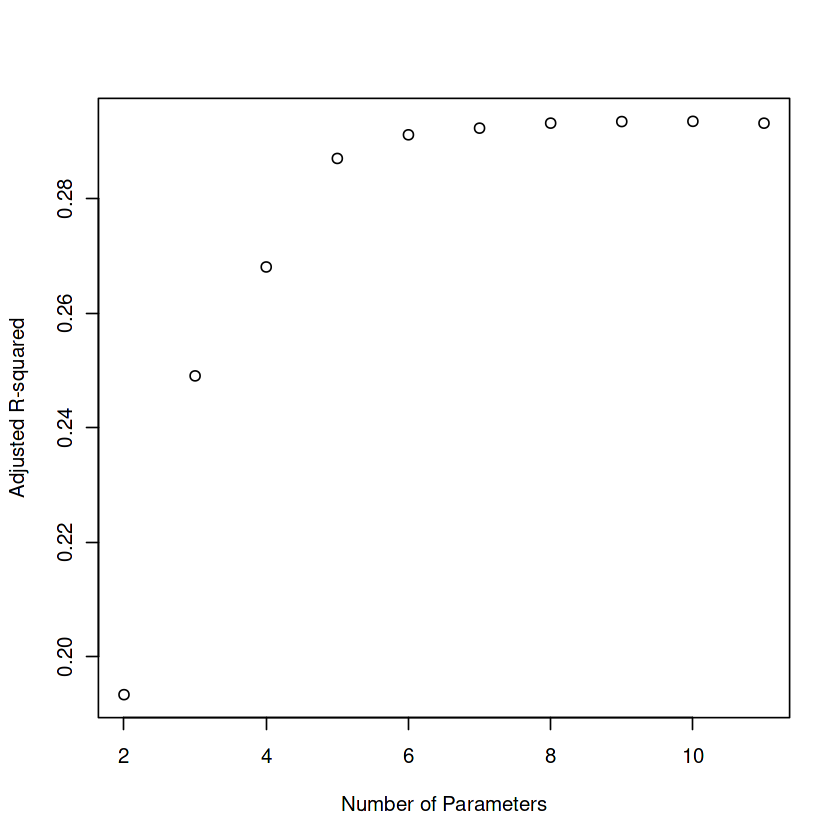

In [33]:
regsubsetsModel <-regsubsets(quality_bin ~.,data=train, nvmax = 10)
summary(regsubsetsModel)
summary<-summary(regsubsetsModel)
plot(2:11, summary$adjr2, xlab="Number of Parameters",ylab="Adjusted R-squared")

which.max(summary$adjr2)

Using Adjusted R2, if we pick the largest adjusted R2, 10 parameters is best 
(the intercept and 9 parameters), i.e. our model removes residual.sugar.

In [34]:
adjustedR2 <- glm(formula = quality_bin ~  volatile.acidity + 
    citric.acid + chlorides + free.sulfur.dioxide + 
    total.sulfur.dioxide + sulphates + alcohol + density + pH, 
    family = "binomial", data = train)

adjustedR2AIC <- AIC(adjustedR2)
adjustedR2BIC <- BIC(adjustedR2)

trainPrediction <- predict(adjustedR2)
adjustedR2RMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(adjustedR2, test)
adjustedR2RMSETest <- rmse(testPrediction, test$quality_bin)

c(adjustedR2RMSETrain, adjustedR2RMSETest, adjustedR2AIC, adjustedR2BIC)

[1]   1.359388   1.329352 927.969768 975.870740

## Mallow's Cp

[1] 7

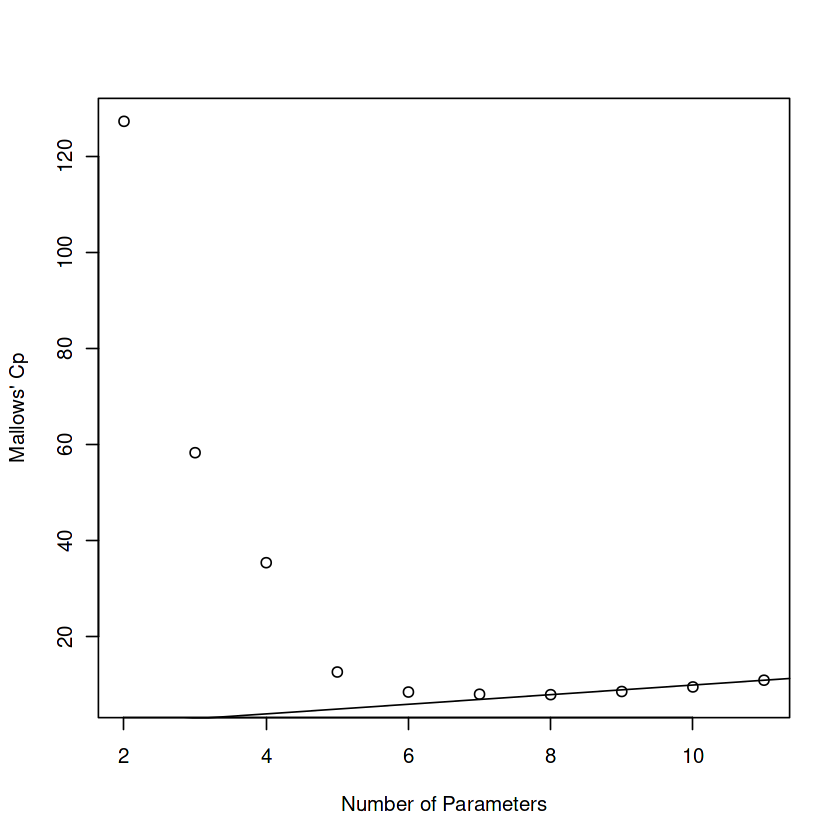

In [35]:
plot(2:11, summary$cp, xlab="Number of Parameters",ylab="Mallows' Cp")
abline(0, 1)

which.min(summary$cp)

Using Mallows' Cp, if we choose the model with the smallest Cp, then seven parameters
is best. i.e. Our model removes residual.sugar, density, pH, and free.sulfur.dioxide.

In [36]:
mallowsCP <- glm(formula = quality_bin ~  volatile.acidity + 
    citric.acid + chlorides + 
    total.sulfur.dioxide + sulphates + alcohol, 
    family = "binomial", data = train)

mallowsCPAIC <- AIC(mallowsCP)
mallowsCPBIC <- BIC(mallowsCP)

trainPrediction <- predict(mallowsCP)
mallowsCPRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(mallowsCP, test)
mallowsCPRMSETest <- rmse(testPrediction, test$quality_bin)

c(mallowsCPRMSETrain, mallowsCPRMSETest, mallowsCPAIC, mallowsCPBIC)

[1]   1.346493   1.308534 927.543366 961.074047

## LASSO

In [37]:
# split train and test into X and Y
train_X = as.matrix(subset(train, select=-quality_bin))
test_X = as.matrix(subset(test, select=-quality_bin))
train_Y = as.matrix(train["quality_bin"])
test_Y = as.matrix(test["quality_bin"])

[1] 0.01344896

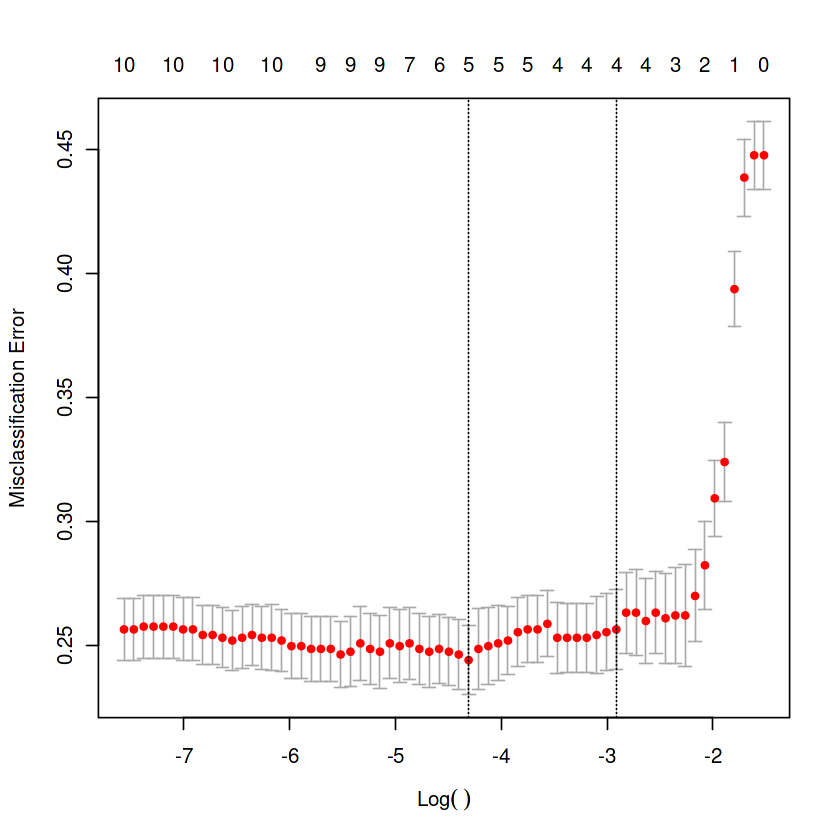

In [38]:
lasso <- glmnet(x=train_X, y=train_Y, family = "binomial")

#perform k-fold cross-validation to find optimal lambda value
cv_model <- cv.glmnet(train_X, train_Y, alpha = 1, family = "binomial", type.measure = "class")

#find optimal lambda value that minimizes test MSE
best_lambda <- cv_model$lambda.min
best_lambda

#produce plot of test MSE by lambda value
plot(cv_model) 

In [39]:
bestLasso <- glmnet(train_X, train_Y, alpha = 1, lambda = best_lambda)
coef(bestLasso)

11 x 1 sparse Matrix of class "dgCMatrix"
                               s0
(Intercept)          -0.950782201
volatile.acidity     -0.476387564
citric.acid           .          
residual.sugar        .          
chlorides            -0.415864883
free.sulfur.dioxide   .          
total.sulfur.dioxide -0.001885688
density               .          
pH                    .          
sulphates             0.434695605
alcohol               0.152565838

In [40]:
tLL <- bestLasso$nulldev - deviance(bestLasso)
k <- bestLasso$df
n <- bestLasso$nobs
bestLassoAIC <- -tLL+2*k+2*k*(k+1)/(n-k-1)
#bestLassoAIC

bestLassoBIC<-log(n) * k - tLL
#bestLassoBIC

trainPrediction <- predict(bestLasso, newx=train_X, type = "response")
lassoRMSETrain <- rmse(trainPrediction, train_Y)

testPrediction <- predict(bestLasso, newx=test_X, type = "response")
lassoRMSETest <- rmse(testPrediction, test_Y)

c(lassoRMSETrain, lassoRMSETest, bestLassoAIC, bestLassoBIC)

[1]   0.4184269   0.4197740 -54.1027427 -30.2202067

## Logistic Regression Results

In [41]:
results <- data.frame(method = c("Full Model", 
                                 "Backwards Selection: P-Value", 
                                 "Backwards Selection: AIC", 
                                 "Forwards Selection: AIC", 
                                 "Stepwise Both: AIC", 
                                 "Backwards Selection: BIC",
                                 "Forwards Selection: BIC",
                                 "Stepwise Both: BIC",
                                 "Adjusted R^2",
                                 "Mallow's Cp",
                                 "LASSO"),
                      trainData_RMSE = c(round(logRegRMSETrain, 5), 
                                         round(backwardsSelectionPValueRMSETrain, 5),
                                         round(backwardsSelectionAICRMSETrain, 5),
                                         round(forwardsSelectionAICRMSETrain, 5), 
                                         round(stepwiseBothAICRMSETrain, 5),
                                         round(backwardsSelectionBICRMSETrain, 5),
                                         round(forwardsSelectionBICRMSETrain, 5),
                                         round(stepwiseBothBICRMSETrain, 5),
                                         round(adjustedR2RMSETrain, 5),
                                         round(mallowsCPRMSETrain, 5),
                                         round(lassoRMSETrain, 5)),
                      testData_RMSE = c(round(logRegRMSETest, 5), 
                                        round(backwardsSelectionPValueRMSETest, 5), 
                                        round(backwardsSelectionAICRMSETest, 5), 
                                        round(forwardsSelectionAICRMSETest, 5), 
                                        round(stepwiseBothAICRMSETest, 5),
                                        round(backwardsSelectionBICRMSETest, 5),
                                        round(forwardsSelectionBICRMSETest, 5),
                                        round(stepwiseBothBICRMSETest, 5),
                                        round(adjustedR2RMSETest, 5),
                                        round(mallowsCPRMSETest, 5),
                                        round(lassoRMSETest, 5)),
                      AIC = c(round(logRegAIC, 5),
                              round(backwardsSelectionPValueAIC, 5),
                              round(backwardsSelectionAICAIC, 5),
                              round(forwardsSelectionAICAIC, 5),
                              round(stepwiseBothAICAIC, 5),
                              round(backwardsSelectionBICAIC, 5),
                              round(forwardsSelectionBICAIC, 5),
                              round(stepwiseBothBICAIC, 5),
                              round(adjustedR2AIC, 5),
                              round(mallowsCPAIC, 5),
                              round(bestLassoAIC, 5)),
                      BIC = c(round(logRegBIC, 5),
                              round(backwardsSelectionPValueBIC, 5),
                              round(backwardsSelectionAICBIC, 5),
                              round(forwardsSelectionAICBIC, 5),
                              round(stepwiseBothAICBIC, 5),
                              round(backwardsSelectionBICBIC, 5),
                              round(forwardsSelectionBICBIC, 5),
                              round(stepwiseBothBICBIC, 5),
                              round(adjustedR2BIC, 5),
                              round(mallowsCPBIC, 5),
                              round(bestLassoBIC, 5)))
results

method,trainData_RMSE,testData_RMSE,AIC,BIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Full Model,1.35946,1.33586,929.62889,982.31996
Backwards Selection: P-Value,1.34649,1.30853,927.54337,961.07405
Backwards Selection: AIC,1.35594,1.33084,926.35414,964.67491
Forwards Selection: AIC,1.35946,1.33586,929.62889,982.31996
Stepwise Both: AIC,1.35594,1.33084,926.35414,964.67491
Backwards Selection: BIC,1.34142,1.30672,926.14742,954.88800
Forwards Selection: BIC,1.35946,1.33586,929.62889,982.31996
Stepwise Both: BIC,1.34142,1.30672,926.14742,954.88800
Adjusted R^2,1.35939,1.32935,927.96977,975.87074


## Conclusions
In looking at the model selection methods above with lowest RMSE, LASSO produces the best model, followed by Backwards Selection BIC/Stepwise Both BIC (same model). Overall, all of the selection methods produce reasonable models based on RMSE. 

## X Variable Transformations

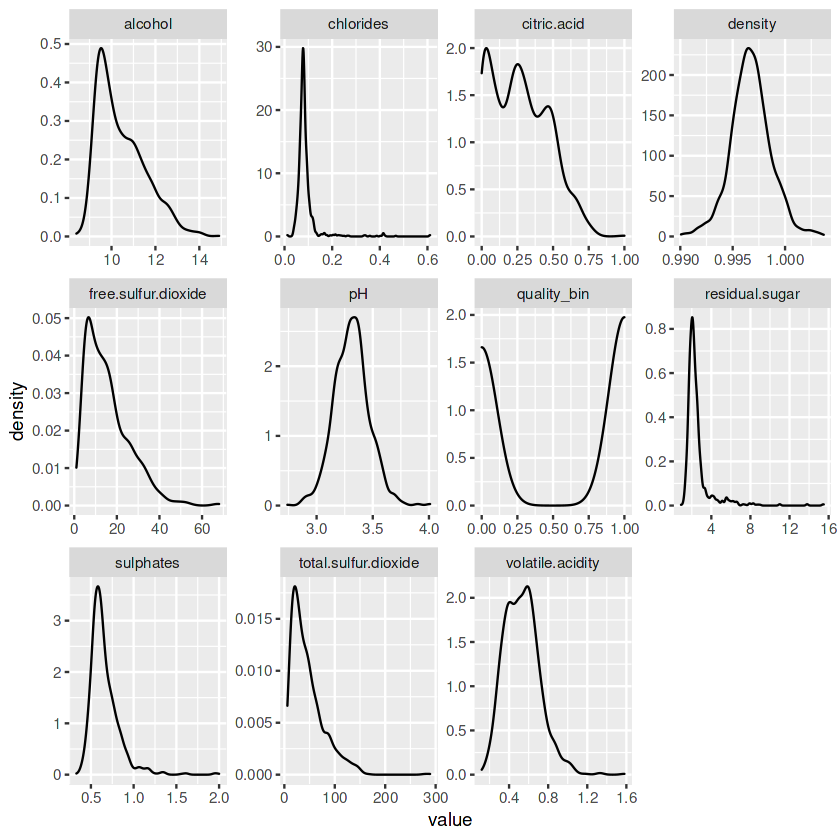

In [42]:
# Predictor Variable Investigation 
df_bin %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density()

### 2. Cholorides Transform

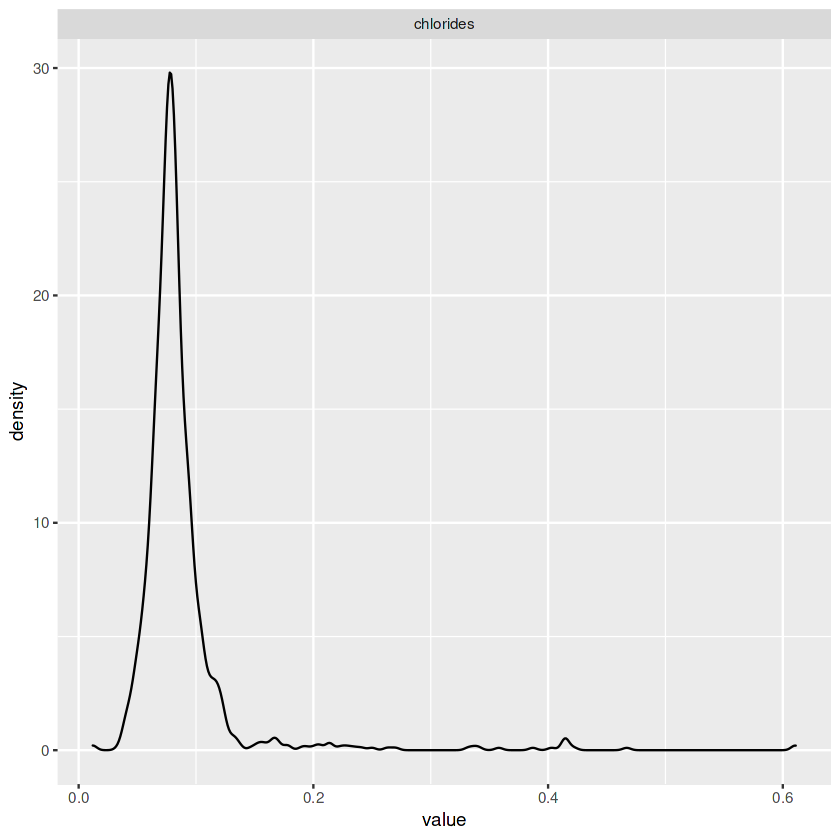

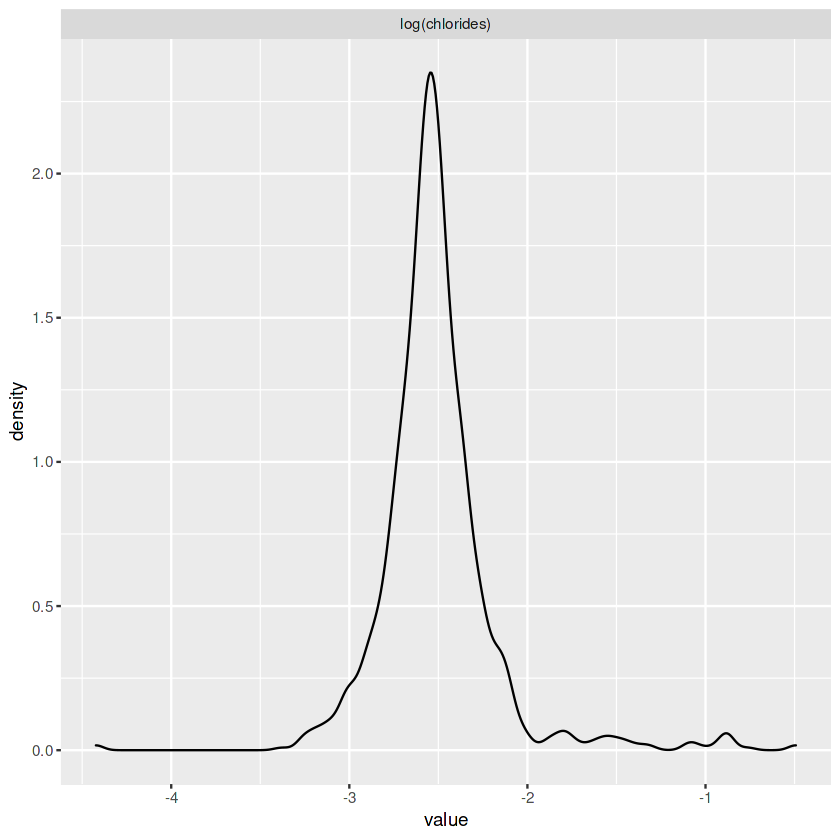

In [43]:
df_bin["log(chlorides)"] <- log(df_bin["chlorides"])
df_bin["chlorides"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

df_bin["log(chlorides)"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

### 3. Citric Acid Transform

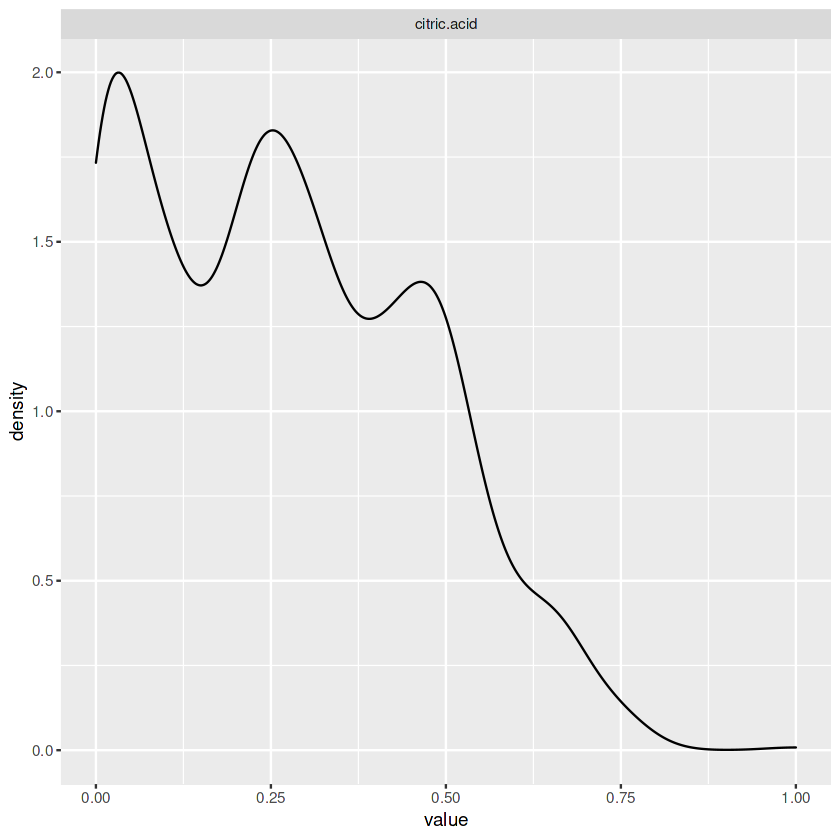

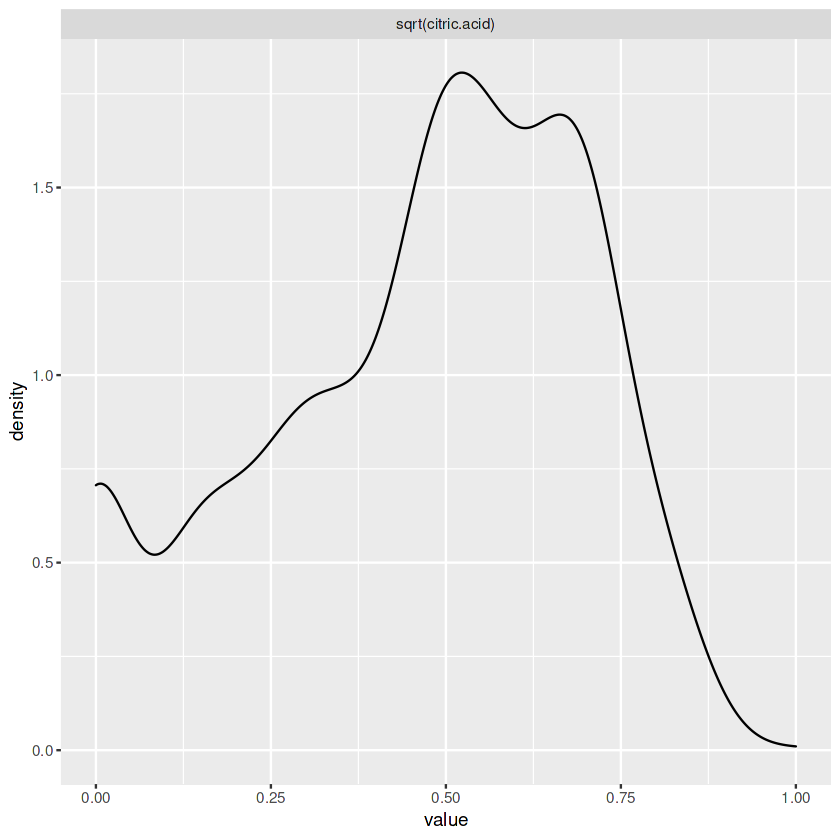

In [44]:
df_bin["sqrt(citric.acid)"] <- sqrt(df_bin["citric.acid"])
df_bin["citric.acid"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

df_bin["sqrt(citric.acid)"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

### 5. Free Sulfur Dioxide Transform

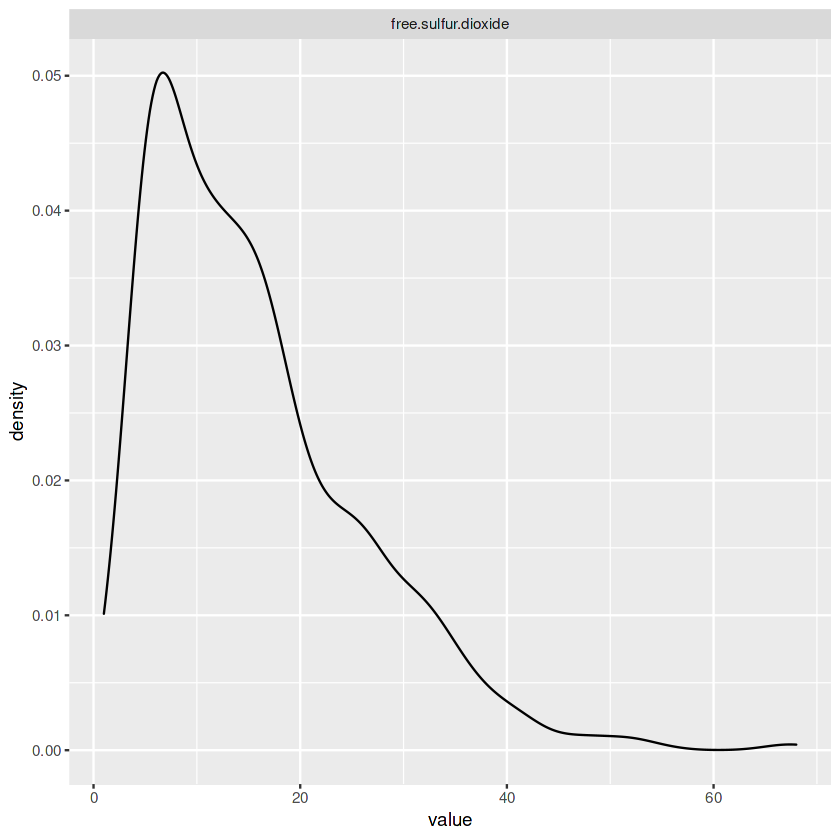

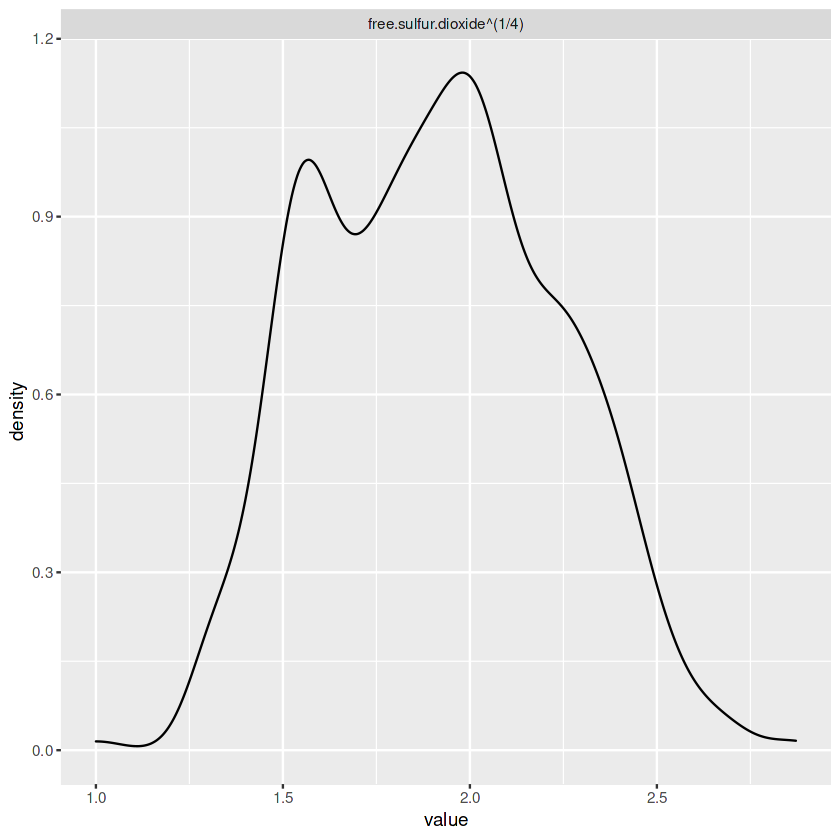

In [45]:
df_bin["free.sulfur.dioxide^(1/4)"] <- (df_bin["free.sulfur.dioxide"])^(1/4)
df_bin["free.sulfur.dioxide"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

df_bin["free.sulfur.dioxide^(1/4)"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

### 7. Residual Sugar Transform

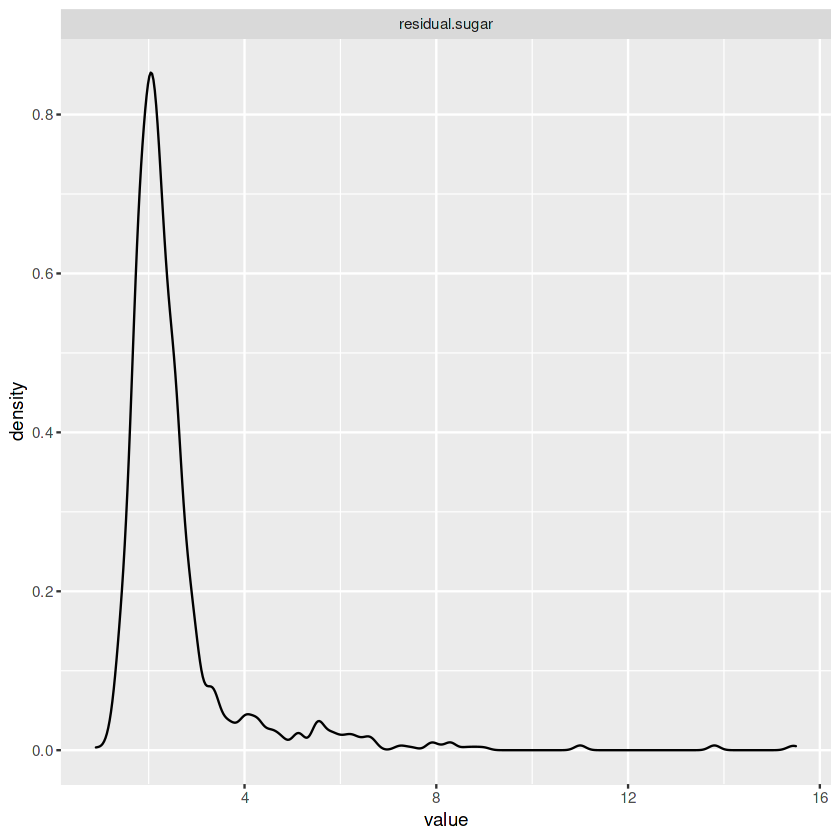

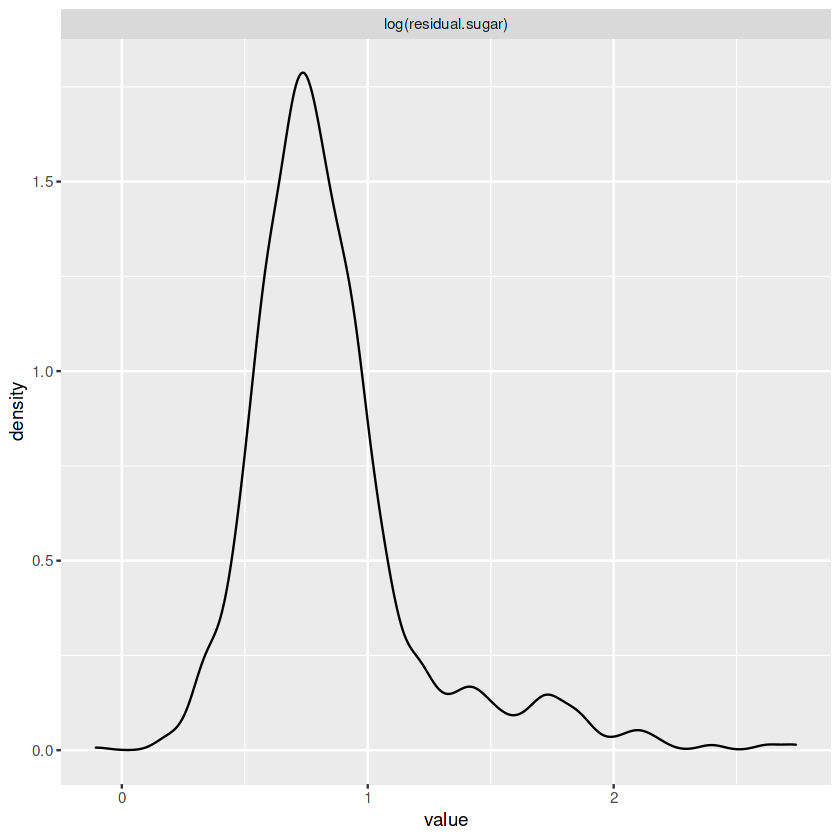

In [46]:
df_bin["log(residual.sugar)"] <- log(df_bin["residual.sugar"])
df_bin["residual.sugar"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

df_bin["log(residual.sugar)"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

### 8. Sulphates Transform

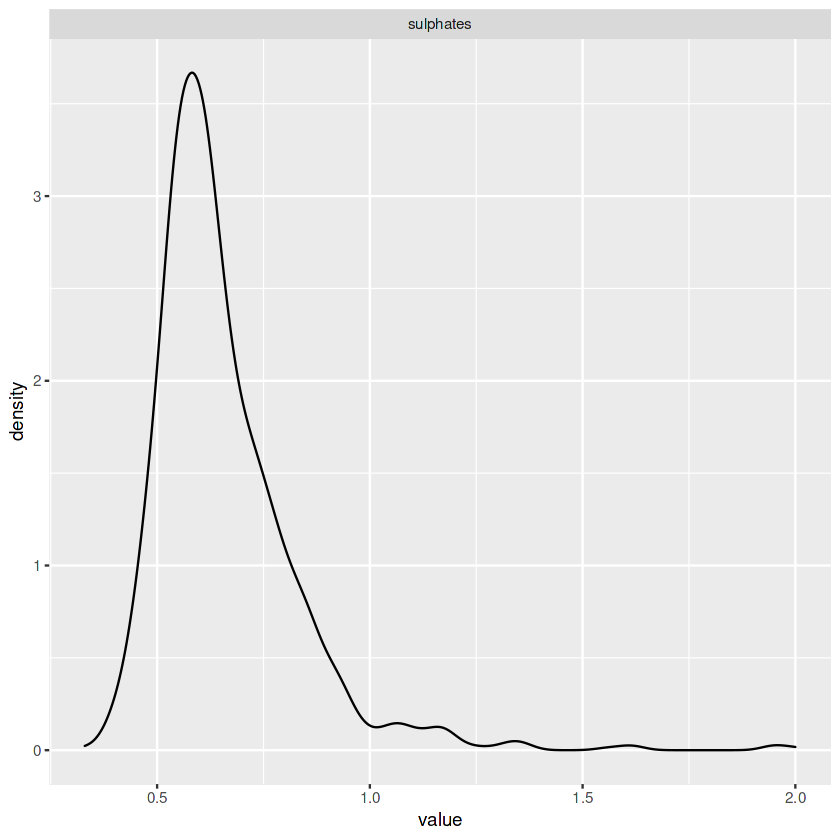

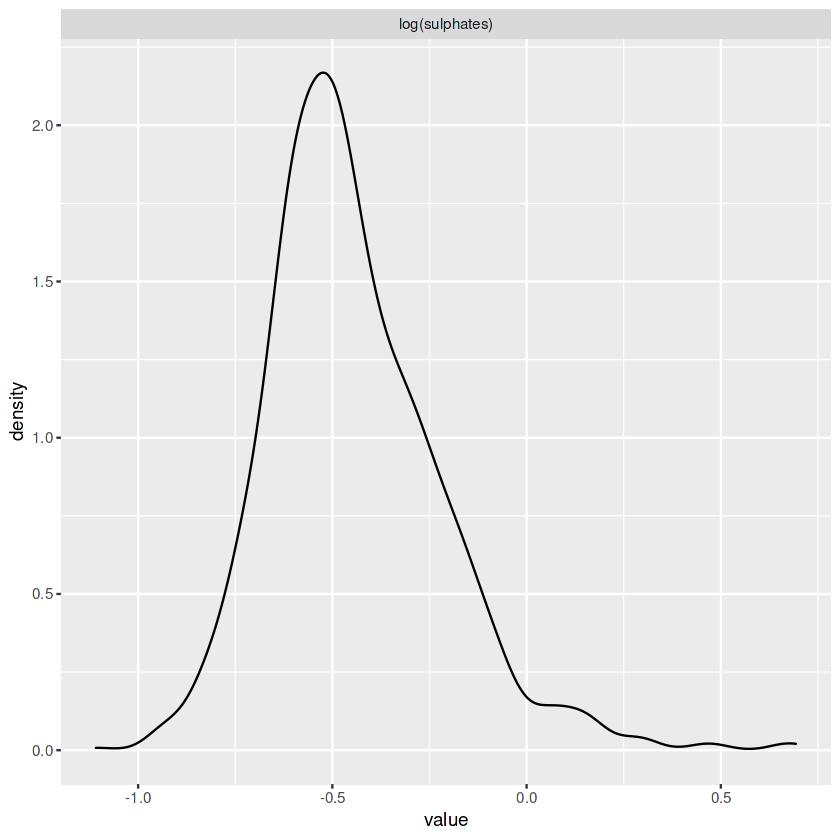

In [47]:
df_bin["log(sulphates)"] <- log(df_bin["sulphates"])
df_bin["sulphates"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

df_bin["log(sulphates)"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

### 9. Total Sulfur Dioxide Transform

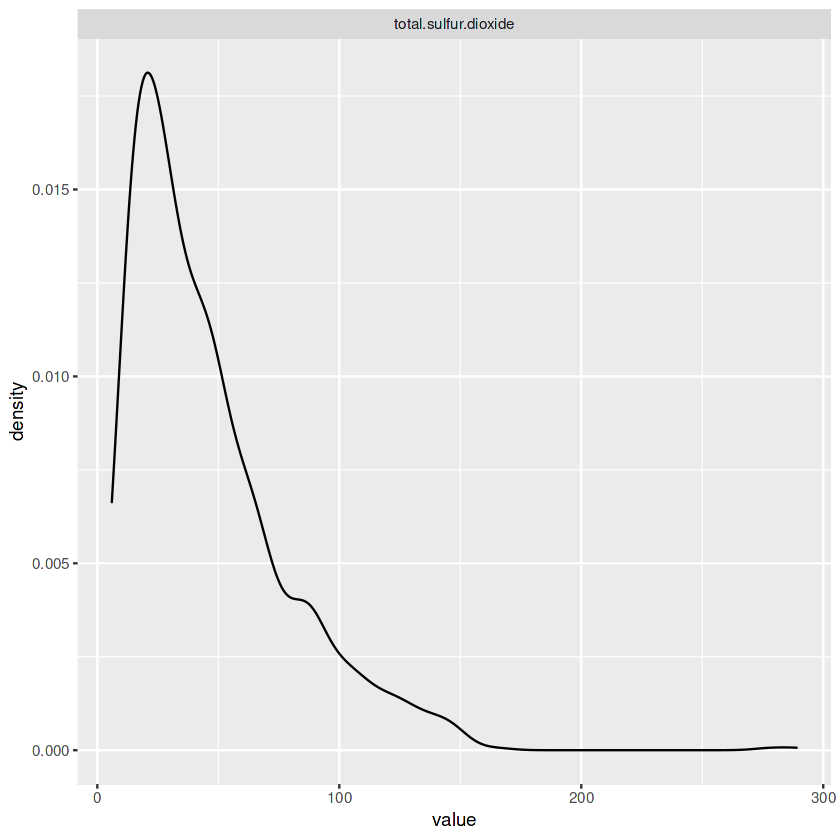

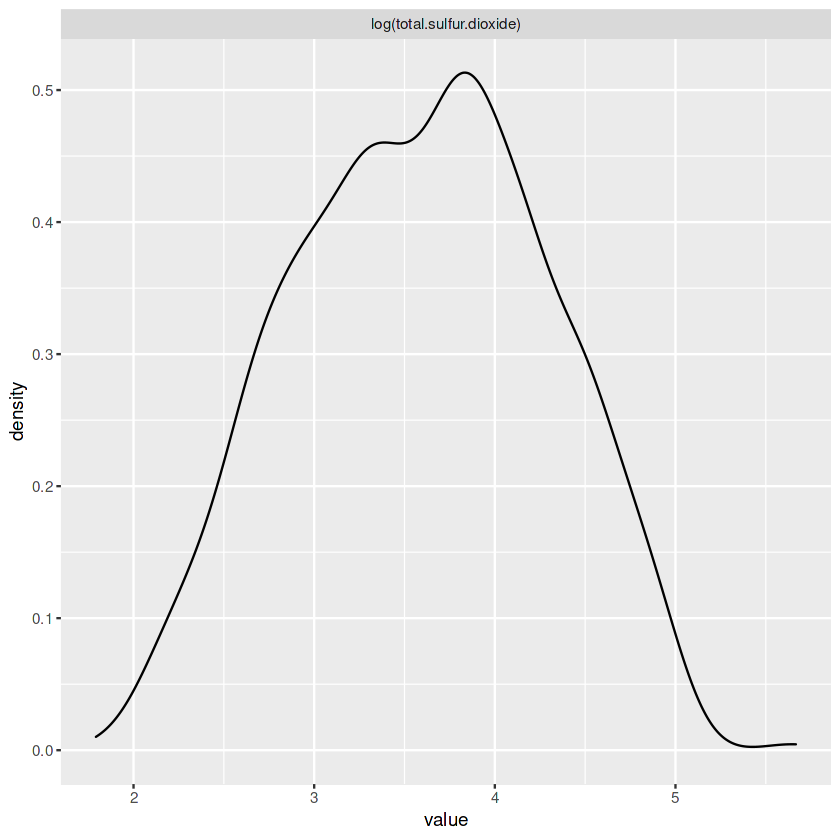

In [48]:
df_bin["log(total.sulfur.dioxide)"] <- log(df_bin["total.sulfur.dioxide"])
df_bin["total.sulfur.dioxide"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

df_bin["log(total.sulfur.dioxide)"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

### 10. Volatile Acidity Transform

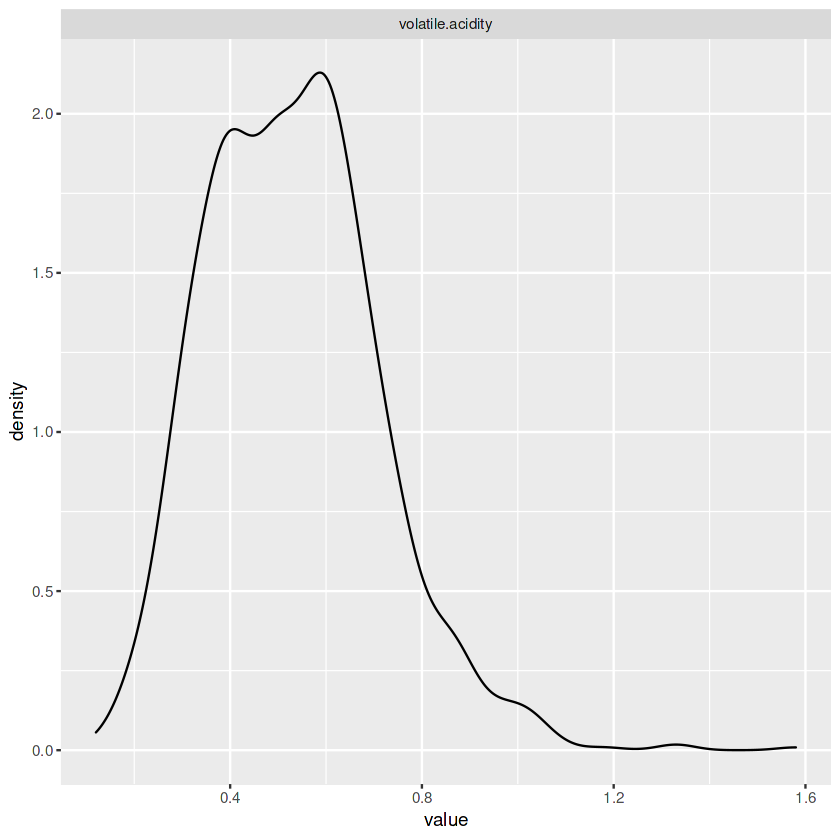

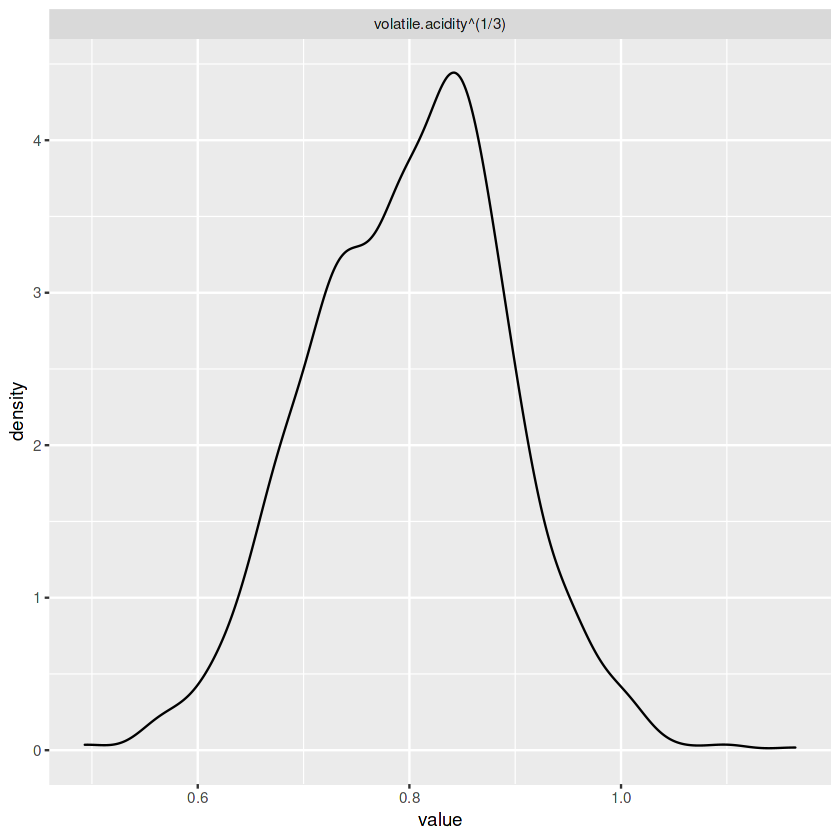

In [49]:
df_bin["volatile.acidity^(1/3)"] <- df_bin["volatile.acidity"]^(1/3)
df_bin["volatile.acidity"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

df_bin["volatile.acidity^(1/3)"] %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density() 

### Summary
1. alcohol - no transform as we cannot find a transform to normalize
1. chlorides - log transform
1. citric.acid - sqrt transform
1. density - no transform, already normal
1. free.sulfur.dioxide - fourth root transform
1. pH - no transform, already normal
1. residual.sugar - log transform
1. sulphates - log transform
1. total.sulfur.dioxide - log transform
1. volatile.acidity - cube root transform

In [50]:
df_bin_transformed <- subset(df_bin, select=-c(chlorides, citric.acid, free.sulfur.dioxide, residual.sugar, sulphates, total.sulfur.dioxide, volatile.acidity))
colnames(df_bin_transformed)

[1] "density"                   "pH"                       
 [3] "alcohol"                   "quality_bin"              
 [5] "log(chlorides)"            "sqrt(citric.acid)"        
 [7] "free.sulfur.dioxide^(1/4)" "log(residual.sugar)"      
 [9] "log(sulphates)"            "log(total.sulfur.dioxide)"
[11] "volatile.acidity^(1/3)"

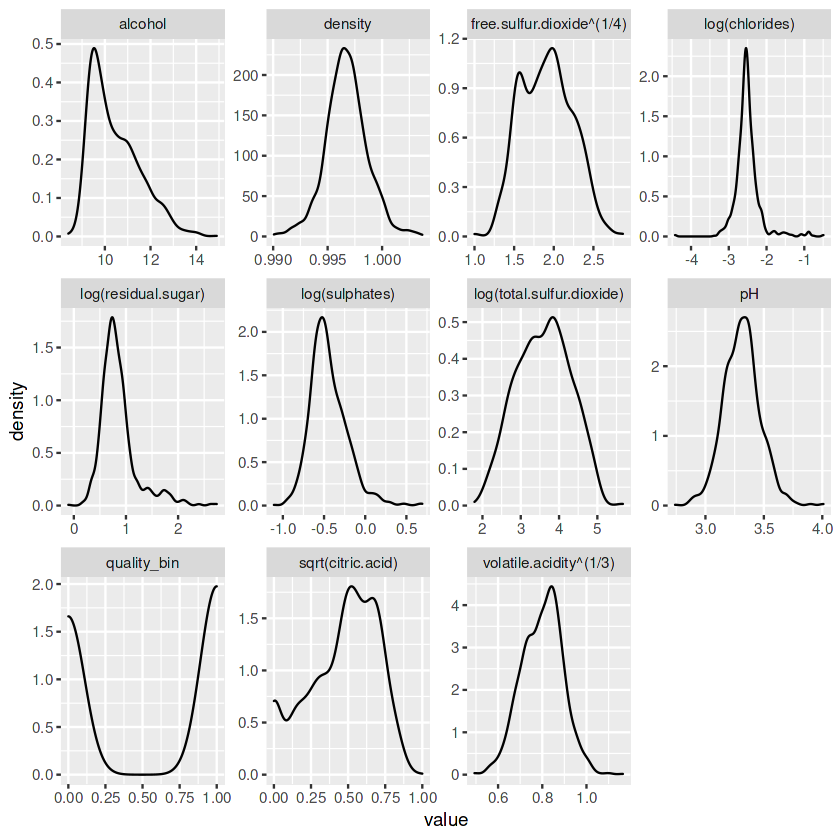

In [51]:
# Predictor Variable Investigation 
df_bin_transformed %>%
  keep(is.numeric) %>%                     # Keep only numeric columns
  gather() %>%                             # Convert to key-value pairs
  ggplot(aes(value)) +                     # Plot the values
    facet_wrap(~ key, scales = "free") +   # In separate panels
    geom_density()

## Rerun Logistic Models with Transformed Variables

In [52]:
sampleTransformed <- sample(c(TRUE, FALSE), nrow(df_bin_transformed), replace=TRUE, prob=c(0.8,0.2))
train <- df_bin_transformed[sample, ]
test <- df_bin_transformed[!sample, ]

## Basic Logistic Regression with Transformed Variables

In [53]:
log_mod = glm(formula=quality_bin~.,data=train,family="binomial")
summary(log_mod)

logRegAIC <- AIC(log_mod)
logRegBIC <- BIC(log_mod)

trainPrediction <- predict(log_mod)
logRegRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(log_mod, test)
logRegRMSETest <- rmse(testPrediction, test$quality_bin)

c(logRegRMSETrain, logRegRMSETest, logRegAIC, logRegBIC)


Call:
glm(formula = quality_bin ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3878  -0.8230   0.3094   0.7659   2.3241  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -161.6545    71.7419  -2.253   0.0242 *  
density                      160.4048    71.4142   2.246   0.0247 *  
pH                            -0.9677     0.6656  -1.454   0.1460    
alcohol                        1.0810     0.1311   8.248  < 2e-16 ***
`log(chlorides)`              -0.5766     0.2921  -1.974   0.0483 *  
`sqrt(citric.acid)`           -1.1784     0.5496  -2.144   0.0320 *  
`free.sulfur.dioxide^(1/4)`    0.6267     0.4404   1.423   0.1548    
`log(residual.sugar)`         -0.3961     0.2960  -1.338   0.1808    
`log(sulphates)`               2.5058     0.4462   5.616 1.95e-08 ***
`log(total.sulfur.dioxide)`   -0.4861     0.2105  -2.310   0.0209 *  
`volatile.acidity^(1/3)`    

[1]   1.364721   1.350117 927.379326 980.070395

## Backward Selection - Transformed Variables
Note we use a p-value of 0.05 as the stopping rule.

In [54]:
summary(log_mod)


Call:
glm(formula = quality_bin ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3878  -0.8230   0.3094   0.7659   2.3241  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -161.6545    71.7419  -2.253   0.0242 *  
density                      160.4048    71.4142   2.246   0.0247 *  
pH                            -0.9677     0.6656  -1.454   0.1460    
alcohol                        1.0810     0.1311   8.248  < 2e-16 ***
`log(chlorides)`              -0.5766     0.2921  -1.974   0.0483 *  
`sqrt(citric.acid)`           -1.1784     0.5496  -2.144   0.0320 *  
`free.sulfur.dioxide^(1/4)`    0.6267     0.4404   1.423   0.1548    
`log(residual.sugar)`         -0.3961     0.2960  -1.338   0.1808    
`log(sulphates)`               2.5058     0.4462   5.616 1.95e-08 ***
`log(total.sulfur.dioxide)`   -0.4861     0.2105  -2.310   0.0209 *  
`volatile.acidity^(1/3)`    

In [55]:
# `free.sulfur.dioxide^(1/4)` the highest p-value 
modelSubset1 <- update(log_mod,. ~ . - `free.sulfur.dioxide^(1/4)`)
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ density + pH + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4059  -0.8336   0.3033   0.7800   2.2821  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -158.7902    71.7947  -2.212   0.0270 *  
density                      157.8038    71.4708   2.208   0.0272 *  
pH                            -0.9066     0.6637  -1.366   0.1720    
alcohol                        1.1065     0.1301   8.508  < 2e-16 ***
`log(chlorides)`              -0.5653     0.2919  -1.937   0.0528 .  
`sqrt(citric.acid)`           -1.3270     0.5402  -2.457   0.0140 *  
`log(residual.sugar)`         -0.4126     0.2987  -1.381   0.1672    
`log(sulphates)`               2.5210     0.4474   5.634 1.76

In [56]:
# `log(residual.sugar)` the highest p-value 
modelSubset1 <- update(modelSubset1,. ~ . -`log(residual.sugar)`)
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ density + pH + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `log(sulphates)` + `log(total.sulfur.dioxide)` + 
    `volatile.acidity^(1/3)`, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4374  -0.8186   0.3002   0.7866   2.2459  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -103.1062    59.3272  -1.738   0.0822 .  
density                      102.3189    59.0392   1.733   0.0831 .  
pH                            -0.8843     0.6620  -1.336   0.1816    
alcohol                        1.0320     0.1173   8.797  < 2e-16 ***
`log(chlorides)`              -0.5914     0.2916  -2.028   0.0426 *  
`sqrt(citric.acid)`           -1.2585     0.5373  -2.342   0.0192 *  
`log(sulphates)`               2.6060     0.4433   5.878 4.14e-09 ***
`log(total.sulfur.dioxide)`   -0.2854     0.1260  -2.265   0.0235 *  
`volatile.acidity^(1

In [57]:
# pH the highest p-value 
modelSubset1 <- update(modelSubset1,. ~ . -pH)
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ density + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `log(sulphates)` + `log(total.sulfur.dioxide)` + 
    `volatile.acidity^(1/3)`, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3402  -0.8211   0.3090   0.8098   2.2514  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -108.6085    58.9650  -1.842   0.0655 .  
density                      105.2455    58.7714   1.791   0.0733 .  
alcohol                        1.0043     0.1149   8.740  < 2e-16 ***
`log(chlorides)`              -0.5222     0.2853  -1.830   0.0672 .  
`sqrt(citric.acid)`           -0.9667     0.4895  -1.975   0.0483 *  
`log(sulphates)`               2.5640     0.4374   5.862 4.59e-09 ***
`log(total.sulfur.dioxide)`   -0.2991     0.1253  -2.388   0.0169 *  
`volatile.acidity^(1/3)`      -6.3202     1.2476  -5.066 4.07e-07 ***
---
Signif. codes:  0 ‘**

In [58]:
# density the highest p-value 
modelSubset1 <- update(modelSubset1,. ~ . -density)
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `log(sulphates)` + `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, 
    family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2169  -0.8233   0.3080   0.8075   2.1945  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -3.0868     1.6552  -1.865   0.0622 .  
alcohol                       0.9091     0.1008   9.016  < 2e-16 ***
`log(chlorides)`             -0.5135     0.2854  -1.799   0.0720 .  
`sqrt(citric.acid)`          -0.6199     0.4473  -1.386   0.1658    
`log(sulphates)`              2.6812     0.4348   6.166 6.99e-10 ***
`log(total.sulfur.dioxide)`  -0.3130     0.1253  -2.498   0.0125 *  
`volatile.acidity^(1/3)`     -5.8935     1.2125  -4.861 1.17e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family tak

In [59]:
# `log(chlorides)`  the highest p-value 
modelSubset1 <- update(modelSubset1,. ~ . -`log(chlorides)` )
summary(modelSubset1)


Call:
glm(formula = quality_bin ~ alcohol + `sqrt(citric.acid)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2860  -0.8295   0.3177   0.8162   2.2890  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -2.0284     1.5447  -1.313   0.1891    
alcohol                       0.9625     0.0968   9.943  < 2e-16 ***
`sqrt(citric.acid)`          -0.8133     0.4351  -1.869   0.0616 .  
`log(sulphates)`              2.4022     0.4005   5.998 2.00e-09 ***
`log(total.sulfur.dioxide)`  -0.3011     0.1247  -2.415   0.0157 *  
`volatile.acidity^(1/3)`     -6.4108     1.1808  -5.429 5.66e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1222.7  on 888  degrees of freedom
Residual deviance:  9

In [60]:
backwardsSelectionPValue = glm(formula = quality_bin ~ alcohol + `sqrt(citric.acid)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

backwardsSelectionPValueAIC <- AIC(backwardsSelectionPValue)
backwardsSelectionPValueBIC <- BIC(backwardsSelectionPValue)

trainPrediction <- predict(backwardsSelectionPValue)
backwardsSelectionPValueRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(backwardsSelectionPValue, test)
backwardsSelectionPValueRMSETest <- rmse(testPrediction, test$quality_bin)

c(backwardsSelectionPValueRMSETrain, backwardsSelectionPValueRMSETest, backwardsSelectionPValueAIC, backwardsSelectionPValueBIC)

[1]   1.339306   1.315275 929.603806 958.344389

## Backwards Selection AIC: Transformed Variables

In [61]:
step(log_mod, direction="backward")

Start:  AIC=927.38
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`

                              Df Deviance     AIC
- `log(residual.sugar)`        1   907.18  927.18
<none>                             905.38  927.38
- `free.sulfur.dioxide^(1/4)`  1   907.40  927.40
- pH                           1   907.50  927.50
- `log(chlorides)`             1   909.35  929.35
- `sqrt(citric.acid)`          1   910.03  930.03
- density                      1   910.47  930.47
- `log(total.sulfur.dioxide)`  1   910.72  930.72
- `volatile.acidity^(1/3)`     1   930.00  950.00
- `log(sulphates)`             1   940.30  960.30
- alcohol                      1   984.36 1004.36

Step:  AIC=927.18
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(sulphates)` + `log(tota


Call:  glm(formula = quality_bin ~ density + pH + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `free.sulfur.dioxide^(1/4)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

Coefficients:
                (Intercept)                      density  
                  -107.7200                     106.6440  
                         pH                      alcohol  
                    -0.9430                       1.0078  
           `log(chlorides)`          `sqrt(citric.acid)`  
                    -0.6055                      -1.1067  
`free.sulfur.dioxide^(1/4)`             `log(sulphates)`  
                     0.6388                       2.5921  
`log(total.sulfur.dioxide)`     `volatile.acidity^(1/3)`  
                    -0.5273                      -5.9824  

Degrees of Freedom: 888 Total (i.e. Null);  879 Residual
Null Deviance:	    1223 
Residual Deviance: 907.2 	AIC: 927.2

In [62]:
backwardsSelectionAIC = glm(formula = quality_bin ~ density + pH + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

backwardsSelectionAICAIC <- AIC(backwardsSelectionAIC)
backwardsSelectionAICBIC <- BIC(backwardsSelectionAIC)

trainPrediction <- predict(backwardsSelectionAIC)
backwardsSelectionAICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(backwardsSelectionAIC, test)
backwardsSelectionAICRMSETest <- rmse(testPrediction, test$quality_bin)

c(backwardsSelectionAICRMSETrain, backwardsSelectionAICRMSETest, backwardsSelectionAICAIC, backwardsSelectionAICBIC)

[1]   1.371029   1.368717 927.397900 975.298873

## Forwards Selection AIC: Transformed Variables 

In [63]:
step(log_mod, direction="forward")

Start:  AIC=927.38
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`




Call:  glm(formula = quality_bin ~ density + pH + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `free.sulfur.dioxide^(1/4)` + `log(residual.sugar)` + 
    `log(sulphates)` + `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, 
    family = "binomial", data = train)

Coefficients:
                (Intercept)                      density  
                  -161.6545                     160.4048  
                         pH                      alcohol  
                    -0.9677                       1.0810  
           `log(chlorides)`          `sqrt(citric.acid)`  
                    -0.5766                      -1.1784  
`free.sulfur.dioxide^(1/4)`        `log(residual.sugar)`  
                     0.6267                      -0.3961  
           `log(sulphates)`  `log(total.sulfur.dioxide)`  
                     2.5058                      -0.4861  
   `volatile.acidity^(1/3)`  
                    -6.0511  

Degrees of Freedom: 888 Total (i.e. Null);  878 Resid

In [64]:
forwardsSelectionAIC = glm(formula = quality_bin ~., family = "binomial", data = train)

forwardsSelectionAICAIC <- AIC(forwardsSelectionAIC)
forwardsSelectionAICBIC <- BIC(forwardsSelectionAIC)

trainPrediction <- predict(forwardsSelectionAIC)
forwardsSelectionAICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(forwardsSelectionAIC, test)
forwardsSelectionAICRMSETest <- rmse(testPrediction, test$quality_bin)

c(forwardsSelectionAICRMSETrain, forwardsSelectionAICRMSETest, forwardsSelectionAICAIC, forwardsSelectionAICBIC)

[1]   1.364721   1.350117 927.379326 980.070395

## Stepwise Both AIC: Transformed Variables 

In [65]:
step(log_mod, direction="both")

Start:  AIC=927.38
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`

                              Df Deviance     AIC
- `log(residual.sugar)`        1   907.18  927.18
<none>                             905.38  927.38
- `free.sulfur.dioxide^(1/4)`  1   907.40  927.40
- pH                           1   907.50  927.50
- `log(chlorides)`             1   909.35  929.35
- `sqrt(citric.acid)`          1   910.03  930.03
- density                      1   910.47  930.47
- `log(total.sulfur.dioxide)`  1   910.72  930.72
- `volatile.acidity^(1/3)`     1   930.00  950.00
- `log(sulphates)`             1   940.30  960.30
- alcohol                      1   984.36 1004.36

Step:  AIC=927.18
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(sulphates)` + `log(tota


Call:  glm(formula = quality_bin ~ density + pH + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `free.sulfur.dioxide^(1/4)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

Coefficients:
                (Intercept)                      density  
                  -107.7200                     106.6440  
                         pH                      alcohol  
                    -0.9430                       1.0078  
           `log(chlorides)`          `sqrt(citric.acid)`  
                    -0.6055                      -1.1067  
`free.sulfur.dioxide^(1/4)`             `log(sulphates)`  
                     0.6388                       2.5921  
`log(total.sulfur.dioxide)`     `volatile.acidity^(1/3)`  
                    -0.5273                      -5.9824  

Degrees of Freedom: 888 Total (i.e. Null);  879 Residual
Null Deviance:	    1223 
Residual Deviance: 907.2 	AIC: 927.2

In [66]:
stepwiseBothAIC = glm(formula = quality_bin ~ density + pH + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

stepwiseBothAICAIC <- AIC(stepwiseBothAIC)
stepwiseBothAICBIC <- BIC(stepwiseBothAIC)

trainPrediction <- predict(stepwiseBothAIC)
stepwiseBothAICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(stepwiseBothAIC, test)
stepwiseBothAICRMSETest <- rmse(testPrediction, test$quality_bin)

c(stepwiseBothAICRMSETrain, stepwiseBothAICRMSETest, stepwiseBothAICAIC, stepwiseBothAICBIC)

[1]   1.371029   1.368717 927.397900 975.298873

## Backwards Selection BIC: Transformed Variables

In [67]:
step(log_mod, direction="backward", k=log(nrow(train)))

Start:  AIC=980.07
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`

                              Df Deviance     AIC
- `log(residual.sugar)`        1   907.18  975.08
- `free.sulfur.dioxide^(1/4)`  1   907.40  975.30
- pH                           1   907.50  975.40
- `log(chlorides)`             1   909.35  977.25
- `sqrt(citric.acid)`          1   910.03  977.94
- density                      1   910.47  978.37
- `log(total.sulfur.dioxide)`  1   910.72  978.62
<none>                             905.38  980.07
- `volatile.acidity^(1/3)`     1   930.00  997.90
- `log(sulphates)`             1   940.30 1008.20
- alcohol                      1   984.36 1052.26

Step:  AIC=975.08
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(sulphates)` + `log(tota


Call:  glm(formula = quality_bin ~ alcohol + `log(sulphates)` + `log(total.sulfur.dioxide)` + 
    `volatile.acidity^(1/3)`, family = "binomial", data = train)

Coefficients:
                (Intercept)                      alcohol  
                    -3.3075                       0.9657  
           `log(sulphates)`  `log(total.sulfur.dioxide)`  
                     2.2478                      -0.3443  
   `volatile.acidity^(1/3)`  
                    -5.2068  

Degrees of Freedom: 888 Total (i.e. Null);  884 Residual
Null Deviance:	    1223 
Residual Deviance: 921.1 	AIC: 931.1

In [68]:
backwardsSelectionBIC <- glm(formula = quality_bin ~ alcohol + `sqrt(citric.acid)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

backwardsSelectionBICAIC <- AIC(backwardsSelectionBIC)
backwardsSelectionBICBIC <- BIC(backwardsSelectionBIC)

trainPrediction <- predict(backwardsSelectionBIC)
backwardsSelectionBICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(backwardsSelectionBIC, test)
backwardsSelectionBICRMSETest <- rmse(testPrediction, test$quality_bin)

c(backwardsSelectionBICRMSETrain, backwardsSelectionBICRMSETest, backwardsSelectionBICAIC, backwardsSelectionBICBIC)

[1]   1.339306   1.315275 929.603806 958.344389

## Forward Selection BIC: Transformed Variables

In [69]:
step(log_mod, direction="forward", k=log(nrow(train)))

Start:  AIC=980.07
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`




Call:  glm(formula = quality_bin ~ density + pH + alcohol + `log(chlorides)` + 
    `sqrt(citric.acid)` + `free.sulfur.dioxide^(1/4)` + `log(residual.sugar)` + 
    `log(sulphates)` + `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, 
    family = "binomial", data = train)

Coefficients:
                (Intercept)                      density  
                  -161.6545                     160.4048  
                         pH                      alcohol  
                    -0.9677                       1.0810  
           `log(chlorides)`          `sqrt(citric.acid)`  
                    -0.5766                      -1.1784  
`free.sulfur.dioxide^(1/4)`        `log(residual.sugar)`  
                     0.6267                      -0.3961  
           `log(sulphates)`  `log(total.sulfur.dioxide)`  
                     2.5058                      -0.4861  
   `volatile.acidity^(1/3)`  
                    -6.0511  

Degrees of Freedom: 888 Total (i.e. Null);  878 Resid

In [70]:
forwardsSelectionBIC <-  glm(formula = quality_bin ~ ., family = "binomial", data = train)

forwardsSelectionBICAIC <- AIC(forwardsSelectionBIC)
forwardsSelectionBICBIC <- BIC(forwardsSelectionBIC)

trainPrediction <- predict(forwardsSelectionBIC)
forwardsSelectionBICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(forwardsSelectionBIC, test)
forwardsSelectionBICRMSETest <- rmse(testPrediction, test$quality_bin)

c(forwardsSelectionBICRMSETrain, forwardsSelectionBICRMSETest, forwardsSelectionBICAIC, forwardsSelectionBICBIC)

[1]   1.364721   1.350117 927.379326 980.070395

## Stepwise Both BIC: Transformed Variables

In [71]:
step(log_mod, direction="both", k=log(nrow(train)))

Start:  AIC=980.07
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(residual.sugar)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`

                              Df Deviance     AIC
- `log(residual.sugar)`        1   907.18  975.08
- `free.sulfur.dioxide^(1/4)`  1   907.40  975.30
- pH                           1   907.50  975.40
- `log(chlorides)`             1   909.35  977.25
- `sqrt(citric.acid)`          1   910.03  977.94
- density                      1   910.47  978.37
- `log(total.sulfur.dioxide)`  1   910.72  978.62
<none>                             905.38  980.07
- `volatile.acidity^(1/3)`     1   930.00  997.90
- `log(sulphates)`             1   940.30 1008.20
- alcohol                      1   984.36 1052.26

Step:  AIC=975.08
quality_bin ~ density + pH + alcohol + `log(chlorides)` + `sqrt(citric.acid)` + 
    `free.sulfur.dioxide^(1/4)` + `log(sulphates)` + `log(tota


Call:  glm(formula = quality_bin ~ alcohol + `log(sulphates)` + `log(total.sulfur.dioxide)` + 
    `volatile.acidity^(1/3)`, family = "binomial", data = train)

Coefficients:
                (Intercept)                      alcohol  
                    -3.3075                       0.9657  
           `log(sulphates)`  `log(total.sulfur.dioxide)`  
                     2.2478                      -0.3443  
   `volatile.acidity^(1/3)`  
                    -5.2068  

Degrees of Freedom: 888 Total (i.e. Null);  884 Residual
Null Deviance:	    1223 
Residual Deviance: 921.1 	AIC: 931.1

In [72]:
stepwiseBothBIC <- glm(formula = quality_bin ~ alcohol + `sqrt(citric.acid)` + `log(sulphates)` + 
    `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)`, family = "binomial", 
    data = train)

stepwiseBothBICAIC <- AIC(stepwiseBothBIC)
stepwiseBothBICBIC <- BIC(stepwiseBothBIC)

trainPrediction <- predict(stepwiseBothBIC)
stepwiseBothBICRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(stepwiseBothBIC, test)
stepwiseBothBICRMSETest <- rmse(testPrediction, test$quality_bin)

c(stepwiseBothBICRMSETrain, stepwiseBothBICRMSETest, stepwiseBothBICAIC, stepwiseBothBICBIC)

[1]   1.339306   1.315275 929.603806 958.344389

## Adjusted R^2: Transformed Variables

Subset selection object
Call: regsubsets.formula(quality_bin ~ ., data = train, nvmax = 10)
10 Variables  (and intercept)
                            Forced in Forced out
density                         FALSE      FALSE
pH                              FALSE      FALSE
alcohol                         FALSE      FALSE
`log(chlorides)`                FALSE      FALSE
`sqrt(citric.acid)`             FALSE      FALSE
`free.sulfur.dioxide^(1/4)`     FALSE      FALSE
`log(residual.sugar)`           FALSE      FALSE
`log(sulphates)`                FALSE      FALSE
`log(total.sulfur.dioxide)`     FALSE      FALSE
`volatile.acidity^(1/3)`        FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          density pH  alcohol `log(chlorides)` `sqrt(citric.acid)`
1  ( 1 )  " "     " " "*"     " "              " "                
2  ( 1 )  " "     " " "*"     " "              " "                
3  ( 1 )  " "     " " "*"     " "              " "                
4  ( 1 

[1] 10

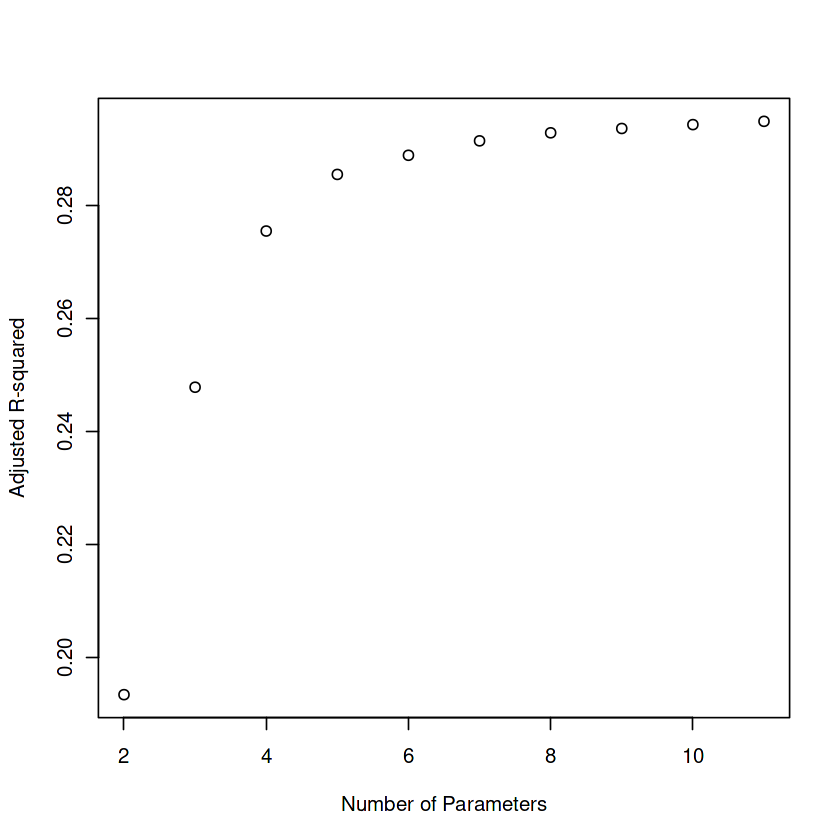

In [73]:
regsubsetsModel <-regsubsets(quality_bin ~.,data=train, nvmax = 10)
summary(regsubsetsModel)
summary<-summary(regsubsetsModel)
plot(2:11, summary$adjr2, xlab="Number of Parameters",ylab="Adjusted R-squared")

which.max(summary$adjr2)

Using Adjusted R2, if we pick the largest adjusted R2, 11 parameters is best 
(the intercept and all 10 parameters).

In [74]:
adjustedR2 <- glm(formula = quality_bin ~ ., family = "binomial", data = train)

adjustedR2AIC <- AIC(adjustedR2)
adjustedR2BIC <- BIC(adjustedR2)

trainPrediction <- predict(adjustedR2)
adjustedR2RMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(adjustedR2, test)
adjustedR2RMSETest <- rmse(testPrediction, test$quality_bin)

c(adjustedR2RMSETrain, adjustedR2RMSETest, adjustedR2AIC, adjustedR2BIC)

[1]   1.364721   1.350117 927.379326 980.070395

## Mallow's Cp: Transformed Variables

[1] 7

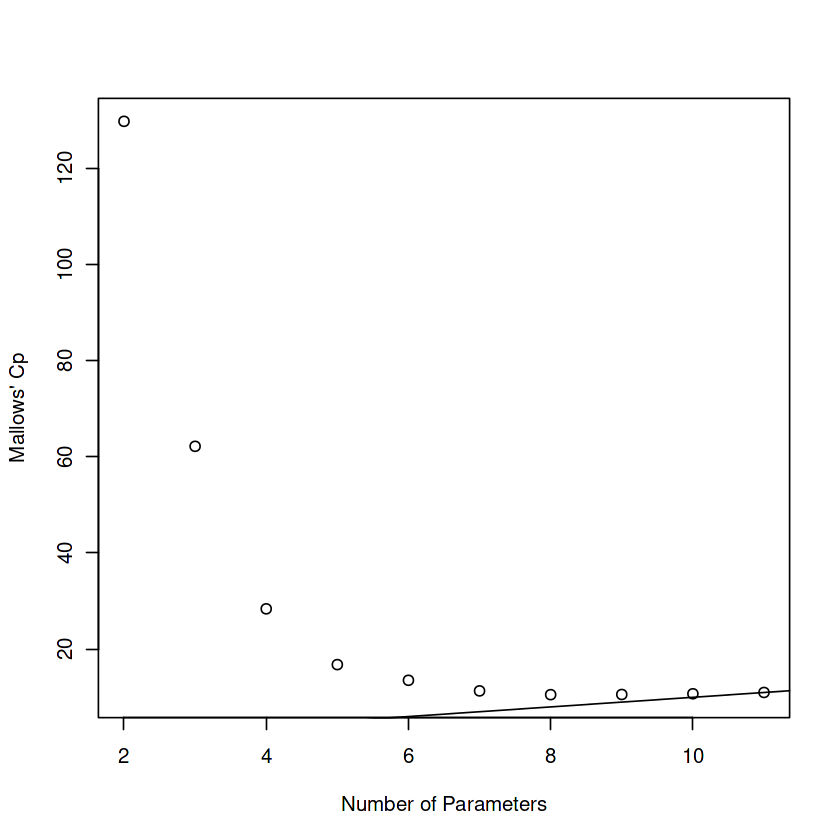

In [75]:
plot(2:11, summary$cp, xlab="Number of Parameters",ylab="Mallows' Cp")
abline(0, 1)
which.min(summary$cp)

Using Mallows' Cp, if we choose the model with the smallest Cp, then nine parameters
is best. i.e. Our model removes density, pH, log(residual.sugar).

In [76]:
mallowsCP <- glm(formula = quality_bin ~ alcohol + `sqrt(citric.acid)` + `free.sulfur.dioxide^(1/4)` +
                   `log(sulphates)` + `log(total.sulfur.dioxide)` + `volatile.acidity^(1/3)` + `log(chlorides)`,
    family = "binomial", data = train)

mallowsCPAIC <- AIC(mallowsCP)
mallowsCPBIC <- BIC(mallowsCP)

trainPrediction <- predict(mallowsCP)
mallowsCPRMSETrain <- rmse(trainPrediction, train$quality_bin)

testPrediction <- predict(mallowsCP, test)
mallowsCPRMSETest <- rmse(testPrediction, test$quality_bin)

c(mallowsCPRMSETrain, mallowsCPRMSETest, mallowsCPAIC, mallowsCPBIC)

[1]   1.344860   1.300542 928.690784 967.011562

## LASSO: Transformed Variables

In [77]:
# split train and test into X and Y
train_X = as.matrix(subset(train, select=-quality_bin))
test_X = as.matrix(subset(test, select=-quality_bin))
train_Y = as.matrix(train["quality_bin"])
test_Y = as.matrix(test["quality_bin"])

[1] 0.01951214

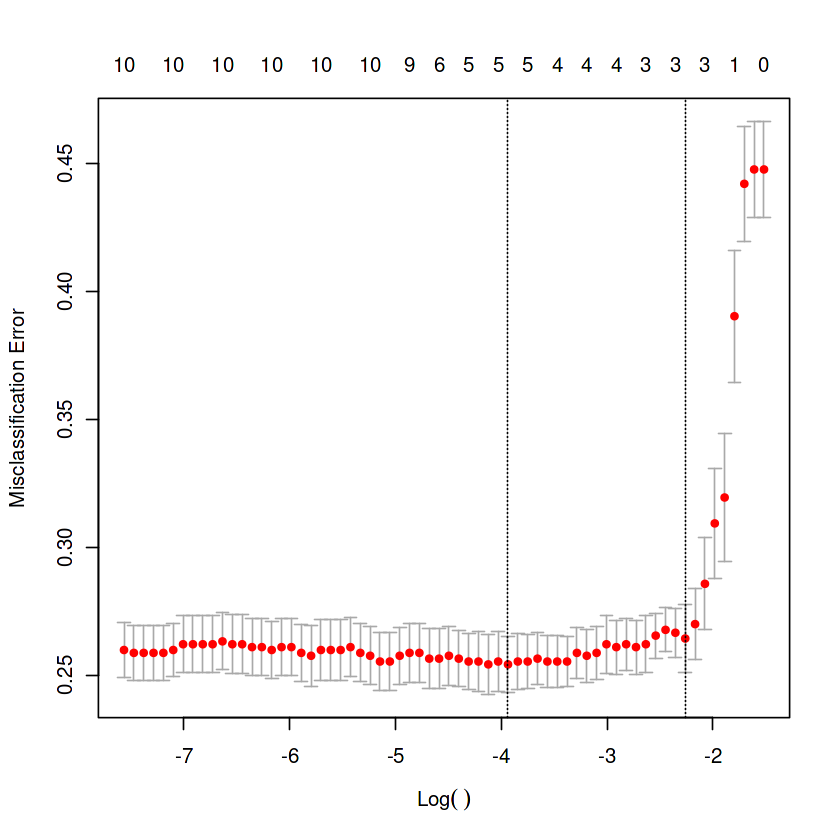

In [78]:
lasso <- glmnet(x=train_X, y=train_Y, family = "binomial")

#perform k-fold cross-validation to find optimal lambda value
cv_model <- cv.glmnet(train_X, train_Y, alpha = 1, family = "binomial", type.measure = "class")

#find optimal lambda value that minimizes test MSE
best_lambda <- cv_model$lambda.min
best_lambda

#produce plot of test MSE by lambda value
plot(cv_model) 

In [79]:
bestLasso <- glmnet(train_X, train_Y, alpha = 1, lambda = best_lambda)
coef(bestLasso)

11 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)               -0.09668311
density                    .         
pH                         .         
alcohol                    0.14872491
log(chlorides)            -0.03486499
sqrt(citric.acid)          .         
free.sulfur.dioxide^(1/4)  .         
log(residual.sugar)        .         
log(sulphates)             0.37651334
log(total.sulfur.dioxide) -0.05368472
volatile.acidity^(1/3)    -0.78935408

In [80]:
tLL <- bestLasso$nulldev - deviance(bestLasso)
k <- bestLasso$df
n <- bestLasso$nobs
bestLassoAIC <- -tLL+2*k+2*k*(k+1)/(n-k-1)
#bestLassoAIC

bestLassoBIC<-log(n) * k - tLL
#bestLassoBIC

trainPrediction <- predict(bestLasso, newx=train_X, type = "response")
lassoRMSETrain <- rmse(trainPrediction, train_Y)

testPrediction <- predict(bestLasso, newx=test_X, type = "response")
lassoRMSETest <- rmse(testPrediction, test_Y)

c(lassoRMSETrain, lassoRMSETest, bestLassoAIC, bestLassoBIC)

[1]   0.4200070   0.4212109 -52.9249699 -29.0424339

## Results for Transformed Variable Logistic Regression Models

In [81]:
results <- data.frame(method = c("Full Model", 
                                 "Backwards Selection: P-Value", 
                                 "Backwards Selection: AIC", 
                                 "Forwards Selection: AIC", 
                                 "Stepwise Both: AIC", 
                                 "Backwards Selection: BIC",
                                 "Forwards Selection: BIC",
                                 "Stepwise Both: BIC",
                                 "Adjusted R^2",
                                 "Mallow's Cp",
                                 "LASSO"),
                      trainData_RMSE = c(round(logRegRMSETrain, 5), 
                                         round(backwardsSelectionPValueRMSETrain, 5),
                                         round(backwardsSelectionAICRMSETrain, 5),
                                         round(forwardsSelectionAICRMSETrain, 5), 
                                         round(stepwiseBothAICRMSETrain, 5),
                                         round(backwardsSelectionBICRMSETrain, 5),
                                         round(forwardsSelectionBICRMSETrain, 5),
                                         round(stepwiseBothBICRMSETrain, 5),
                                         round(adjustedR2RMSETrain, 5),
                                         round(mallowsCPRMSETrain, 5),
                                         round(lassoRMSETrain, 5)),
                      testData_RMSE = c(round(logRegRMSETest, 5), 
                                        round(backwardsSelectionPValueRMSETest, 5), 
                                        round(backwardsSelectionAICRMSETest, 5), 
                                        round(forwardsSelectionAICRMSETest, 5), 
                                        round(stepwiseBothAICRMSETest, 5),
                                        round(backwardsSelectionBICRMSETest, 5),
                                        round(forwardsSelectionBICRMSETest, 5),
                                        round(stepwiseBothBICRMSETest, 5),
                                        round(adjustedR2RMSETest, 5),
                                        round(mallowsCPRMSETest, 5),
                                        round(lassoRMSETest, 5)),
                     AIC = c(round(logRegAIC, 5),
                              round(backwardsSelectionPValueAIC, 5),
                              round(backwardsSelectionAICAIC, 5),
                              round(forwardsSelectionAICAIC, 5),
                              round(stepwiseBothAICAIC, 5),
                              round(backwardsSelectionBICAIC, 5),
                              round(forwardsSelectionBICAIC, 5),
                              round(stepwiseBothBICAIC, 5),
                              round(adjustedR2AIC, 5),
                              round(mallowsCPAIC, 5),
                              round(bestLassoAIC, 5)),
                      BIC = c(round(logRegBIC, 5),
                              round(backwardsSelectionPValueBIC, 5),
                              round(backwardsSelectionAICBIC, 5),
                              round(forwardsSelectionAICBIC, 5),
                              round(stepwiseBothAICBIC, 5),
                              round(backwardsSelectionBICBIC, 5),
                              round(forwardsSelectionBICBIC, 5),
                              round(stepwiseBothBICBIC, 5),
                              round(adjustedR2BIC, 5),
                              round(mallowsCPBIC, 5),
                              round(bestLassoBIC, 5)))

results

method,trainData_RMSE,testData_RMSE,AIC,BIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Full Model,1.36472,1.35012,927.37933,980.07040
Backwards Selection: P-Value,1.33931,1.31527,929.60381,958.34439
Backwards Selection: AIC,1.37103,1.36872,927.39790,975.29887
Forwards Selection: AIC,1.36472,1.35012,927.37933,980.07040
Stepwise Both: AIC,1.37103,1.36872,927.39790,975.29887
Backwards Selection: BIC,1.33931,1.31527,929.60381,958.34439
Forwards Selection: BIC,1.36472,1.35012,927.37933,980.07040
Stepwise Both: BIC,1.33931,1.31527,929.60381,958.34439
Adjusted R^2,1.36472,1.35012,927.37933,980.07040
